<a href="https://colab.research.google.com/github/kussy29/machine_learning/blob/main/lab09_multi_layer_perceptron_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reading MNIST Dataset to Play with It
--------------------

In [1]:
import numpy as np
import torch
import torchvision
from matplotlib import pyplot

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=None)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.05MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.52MB/s]


In [2]:
transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

In [3]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = torch.nn.Sequential(   #Sequential is a structure which allows stacking layers one on another in such a way,
                                          #that output from a preceding layer serves as input to the next layer
            torch.nn.Flatten(),   #change the last three orders in data (with dimensions 1, 28 and 28 respectively) into one order of dimensions (1*28*28)
            torch.nn.Linear(1*28*28, 1024),  #which is used as INPUT to the first Linear layer
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 2048),   #IMPORTANT! Please observe, that the OUTPUT dimension of a preceding layer is always equal to the INPUT dimension of the next layer.
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 256),
            torch.nn.ReLU(),            #ReLU (or a Sigmoid if you want) is a nonlinear function which is used in-between layers
            torch.nn.Linear(256, 10),
        )
        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):
        x = self.mlp(x)
        x = self.dropout(x)
        return x

In [4]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = MLP().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001.

net.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(8):  #  an epoch is a training run through the whole data set

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)  #explicitly moving the data to the target device
        batch_labels = batch_labels.to(device)

        #batch_inputs.squeeze(1)     #alternatively if not for a Flatten layer, squeeze() could be used to remove the second order of the tensor, the Channel, which is one-dimensional (this index can be equal to 0 only)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   #this line calls the forward(self, x) method of the MLP object. Please note, that the last layer of the MLP is linear
                                            #and MLP doesn't apply
                                            #the nonlinear activation after the last layer
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network.
                                ####You can experiment - comment this line and check, that the loss DOE

Working on cuda
epoch: 0 batch: 0 current batch loss: 2.3052120208740234
epoch: 0 batch: 1 current batch loss: 2.0855062007904053
epoch: 0 batch: 2 current batch loss: 1.6208510398864746
epoch: 0 batch: 3 current batch loss: 1.0402168035507202
epoch: 0 batch: 4 current batch loss: 1.008115530014038
epoch: 0 batch: 5 current batch loss: 1.5619966983795166
epoch: 0 batch: 6 current batch loss: 1.2198853492736816
epoch: 0 batch: 7 current batch loss: 0.8966209292411804
epoch: 0 batch: 8 current batch loss: 0.9253057837486267
epoch: 0 batch: 9 current batch loss: 0.7316431999206543
epoch: 0 batch: 10 current batch loss: 0.7003570199012756
epoch: 0 batch: 11 current batch loss: 0.6281865835189819
epoch: 0 batch: 12 current batch loss: 0.59835284948349
epoch: 0 batch: 13 current batch loss: 0.5873504281044006
epoch: 0 batch: 14 current batch loss: 0.6054884195327759
epoch: 0 batch: 15 current batch loss: 0.568716824054718
epoch: 0 batch: 16 current batch loss: 0.499735951423645
epoch: 0 batc

In [48]:
good = 0
wrong = 0

net.eval()              #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing evaluation
with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
    for batch, data in enumerate(testloader): #batches in test are of size 1
        datapoint, label = data

        prediction = net(datapoint.to(device))                  #prediction has values representing the "prevalence" of the corresponding class
        classification = torch.argmax(prediction)    #the class is the index of maximal "prevalence"

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))

accuracy =  0.9788


# **Homework Assignment - *Do Androids Dream of Electric Sheep?***

-------------------------------------  

"Do Androids Dream of Electric Sheep?" – the famous title of Philip K. Dick’s novel – raises a fascinating question: if artificial intelligence could dream, what would it see?  

In this assignment, we explore a phenomenon known as **neural network dreams**, where instead of optimizing a neural network's weights, we **optimize the input itself** to achieve a desired classification outcome. Given a fully trained MNIST classification network, your goal is to manipulate its inputs so that it confidently predicts each digit from 0 to 9, starting from pure noise.  

## **Tasks Description**  

During this class we designed and trained a **MNIST classification neural network**, which takes a **batch of grayscale images** of size **$28 \times 28$** as input and outputs a probability distribution over the 10 digit classes (0–9). However, instead of using real MNIST images, you will **treat the input batch itself as a set of trainable parameters** and optimize it so that the network classifies each image as a specific digit.  

1. Your first task is to generate **a batch of 10 images**, where each image is
   classified as one of the digits **0, 1, 2, ..., 9**, starting from an initial batch of ten random Gaussian noise images.  

   Discuss the following question: do the generated images resemble real MNIST digits? Why or why not?  

2. Discuss, how you would approach a second task of
   generating an image that   
   bares similarity to two or more digits simultaneously. **Implement your idea to see the results.**

3. Third task: repeat the previous tasks with an additional L2 penalty on noise within the images. Experiment with adding `lambda_l2 * dreamed_input_batch.pow(2).mean()` loss term, with `lambda_l2` being the penalty cooefficient within an exponential progression, say from 0.001 to 10.0. Are the new digits recognized correctly? How does the penalty impact the digit quality? Explain.

### **Optimization Process for Task 1**  

1. Start with a **batch of 10 random Gaussian noise images** as the initial input and $(0, 1, 2, \ldots, 9)$ as the expected output batch of target digits.  
2. Define the objective: maximize the neural network's confidence for the corresponding target digit for each image in the batch.  
3. Use **gradient descent** to modify the pixels in each image, making the network classify each one as the assigned digit.  
4. Repeat until the network assigns suffieciently high confidence to each image’s target class.  

### **Implementation Details**  

- The neural network weights **must remain frozen** during optimization. You are modifying only the input images.  
- The loss function should be the **cross-entropy loss** between the predicted probabilities and the desired class labels (plus an optional weighted L2 penalty regularizing the images in task 3).


## **Points to Note**  

1. **Visualize** the optimization process: Save images of the generated inputs at different steps and plot the classification confidence evolution over iterations.  
3. **Document your findings** and explain the behavior you observe.  

## **Task & Deliverables**  

- A **Colab notebook** containing solutions for both tasks:
  - The full implementation.
  - Visualizations of the generated batch of images.
  - A written explanation of your observations.
- **Bonus:** If you create an **animation** showing the evolution of the input images during optimization, it will be considered a strong enhancement to your submission.
  - You can generate an animation programmatically (e.g., using Matplotlib or OpenCV).
  - Or, save image frames and use external tools to create a video.
  - Provide a **link** to any video files in the README.
- Upload your notebook and results to your **GitHub repository** for the course.
- In the **README**, include a **link** to the notebook.
- In the notebook, include **“Open in Colab”** badge so it can be launched directly.




In [45]:
import matplotlib.pyplot as plt
# We create those numbers from normal distribution
labels=torch.tensor([0,1,2,3,4,5,6,7,8,9])
noised_inputs=torch.randn((10,1,28,28))

# We display those numbers
def display_numbers(inputs):
  figure = plt.figure(figsize=(50, 5))
  for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.title(str(labels[i]))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    input=inputs[i].squeeze(0)
    #input*=0.3081
    #input+=0.1307
    #input*=255
    plt.imshow(input)

In [6]:
# We check if model predicts those noise correctly
good=0
wrong=0
with torch.no_grad():
    for i in range(10):
        datapoint= noised_inputs[i]
        label = labels[i]

        prediction = net(datapoint.to(device))
        classification = torch.argmax(prediction)

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))

# No it doesn't predict it correctly

accuracy =  0.0


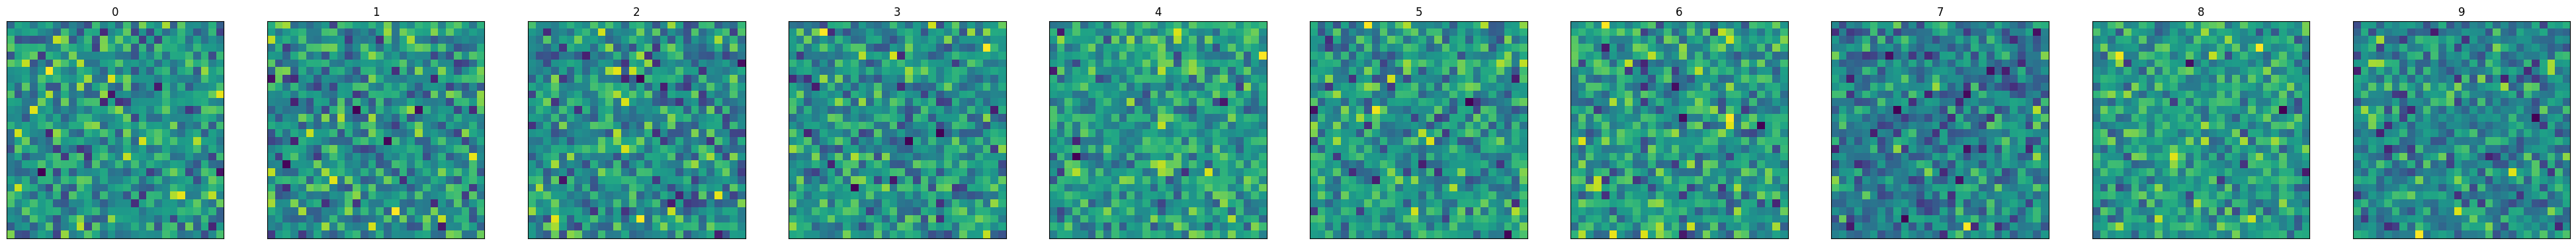

In [7]:
display_numbers(noised_inputs.detach().numpy())


### TASK 1

epoch: 0 current batch loss: 5.605761528015137
epoch: 10 current batch loss: 5.081717491149902
epoch: 20 current batch loss: 4.599974632263184
epoch: 30 current batch loss: 4.153228282928467
epoch: 40 current batch loss: 3.7298903465270996
epoch: 50 current batch loss: 3.3292343616485596
epoch: 60 current batch loss: 2.9511756896972656
epoch: 70 current batch loss: 2.5928268432617188
epoch: 80 current batch loss: 2.255504846572876
epoch: 90 current batch loss: 1.940436601638794
epoch: 100 current batch loss: 1.6454403400421143
epoch: 110 current batch loss: 1.3727701902389526
epoch: 120 current batch loss: 1.1275185346603394
epoch: 130 current batch loss: 0.9114400148391724
epoch: 140 current batch loss: 0.7211105227470398
epoch: 150 current batch loss: 0.5620689988136292
epoch: 160 current batch loss: 0.4314518868923187
epoch: 170 current batch loss: 0.3320004343986511
epoch: 180 current batch loss: 0.2582215666770935
epoch: 190 current batch loss: 0.20395319163799286


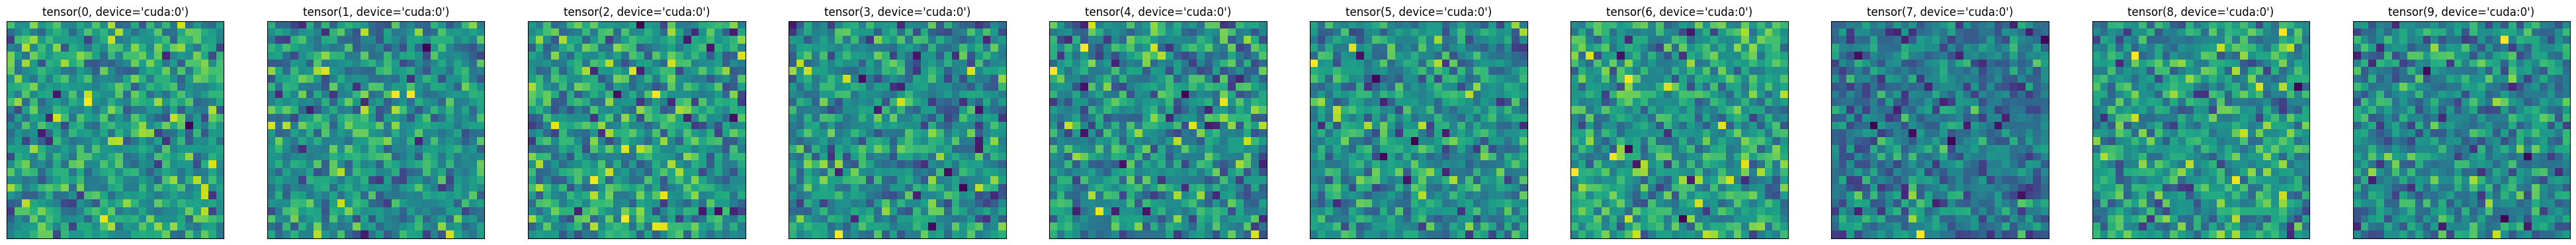

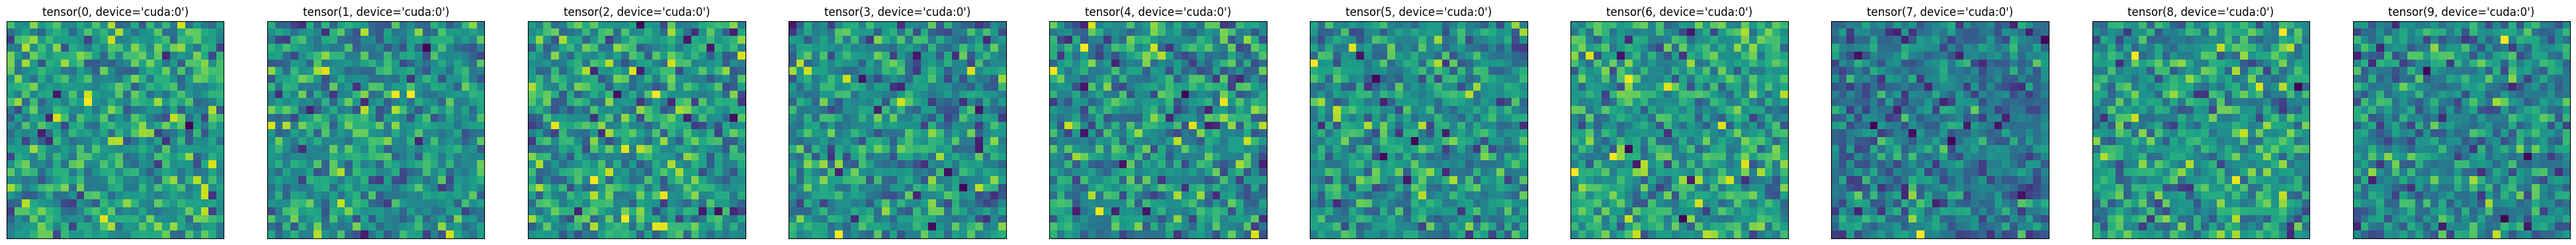

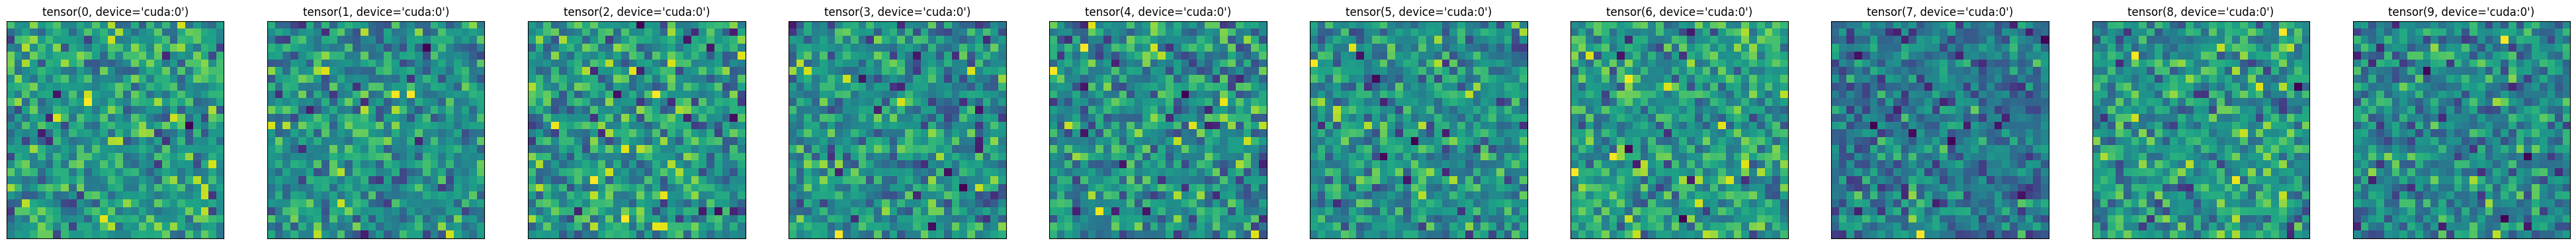

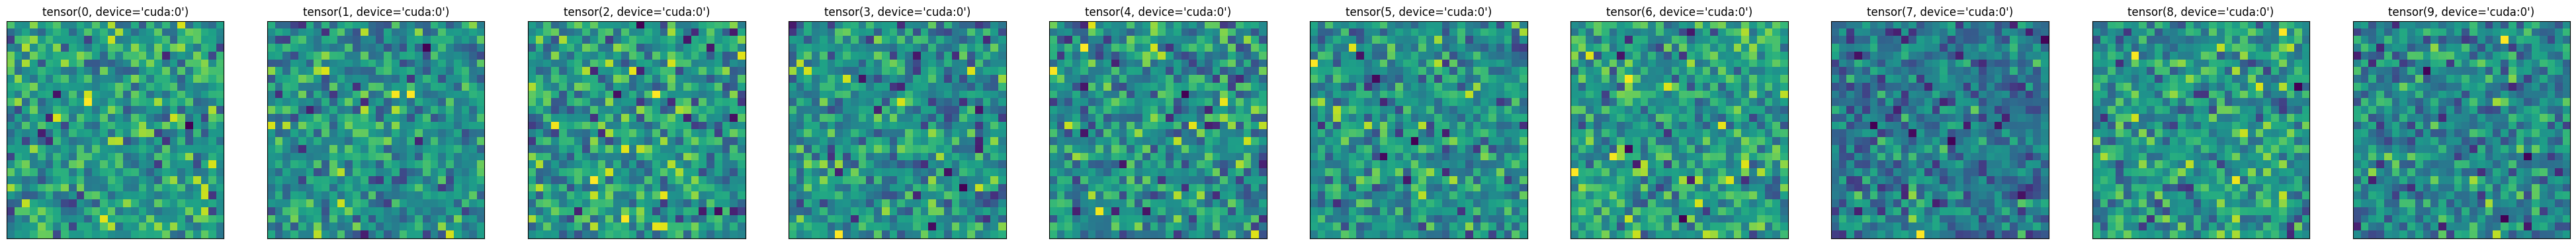

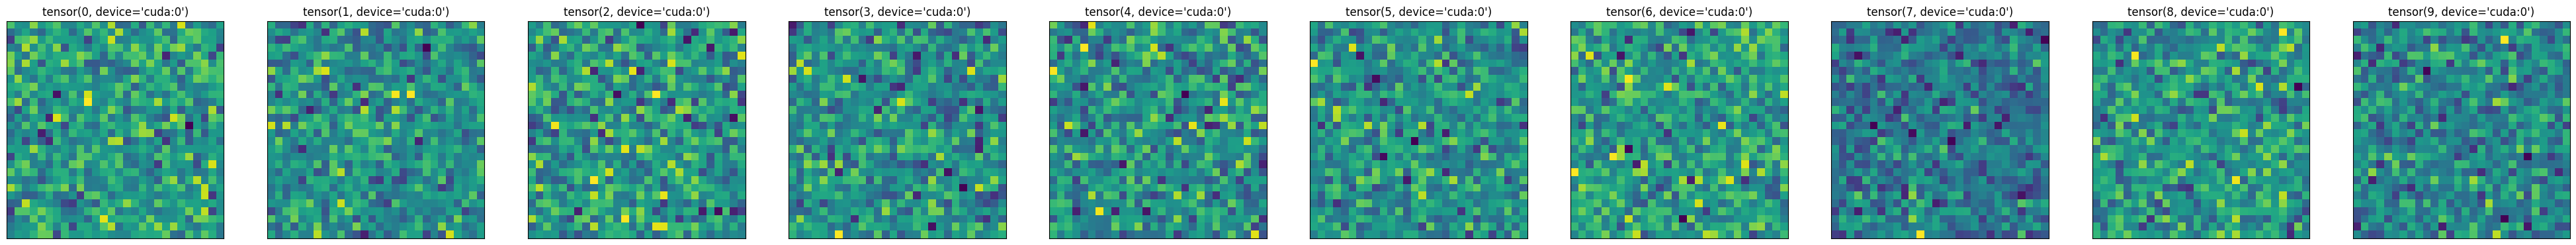

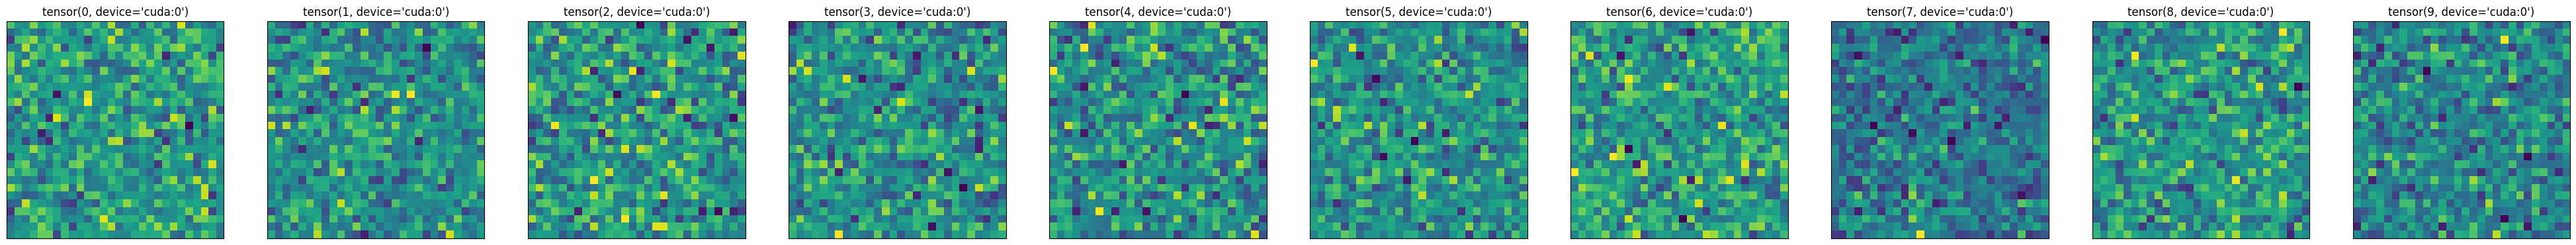

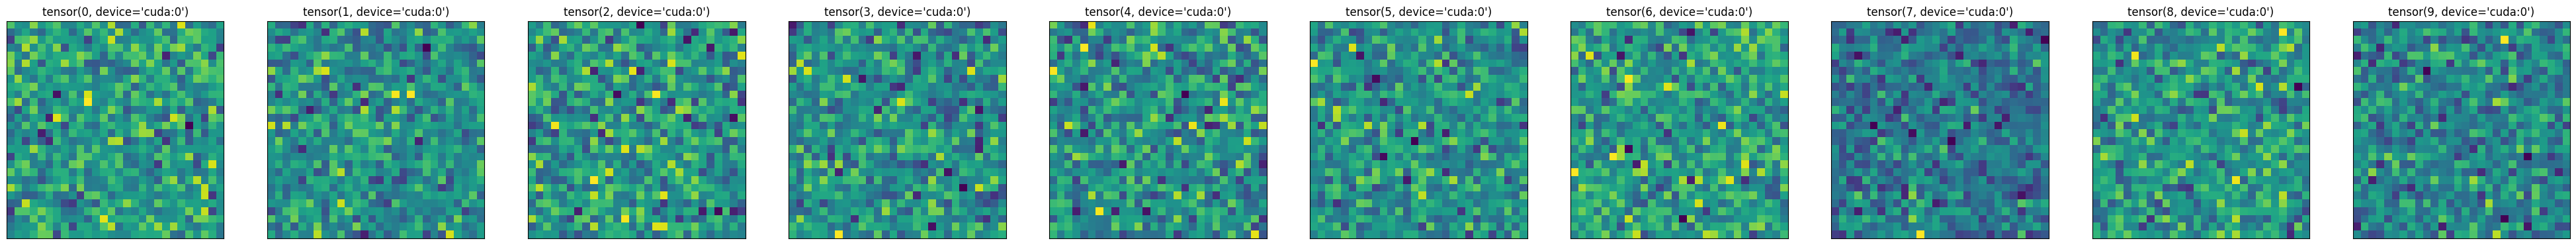

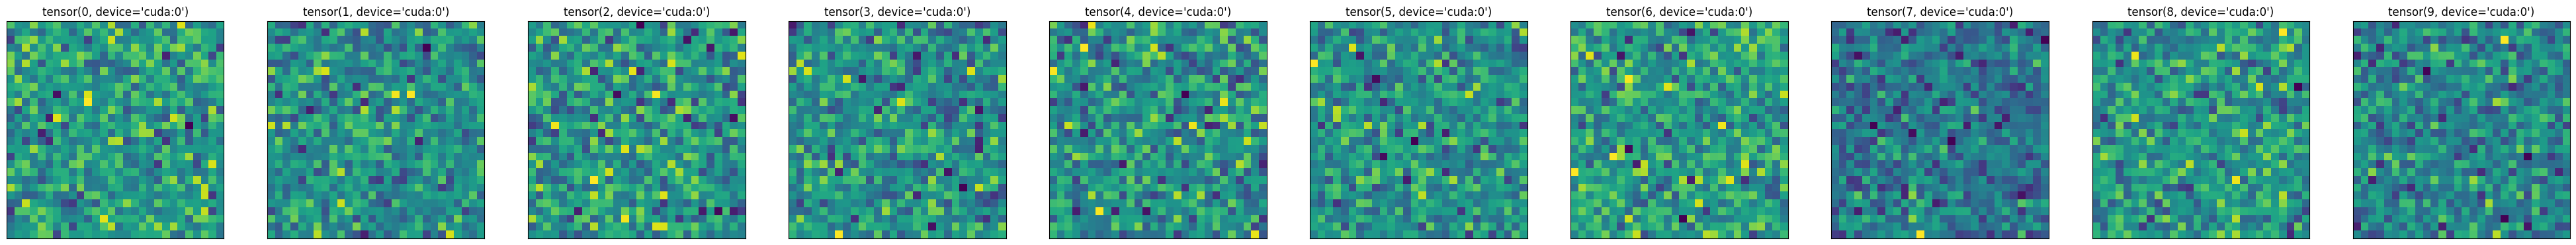

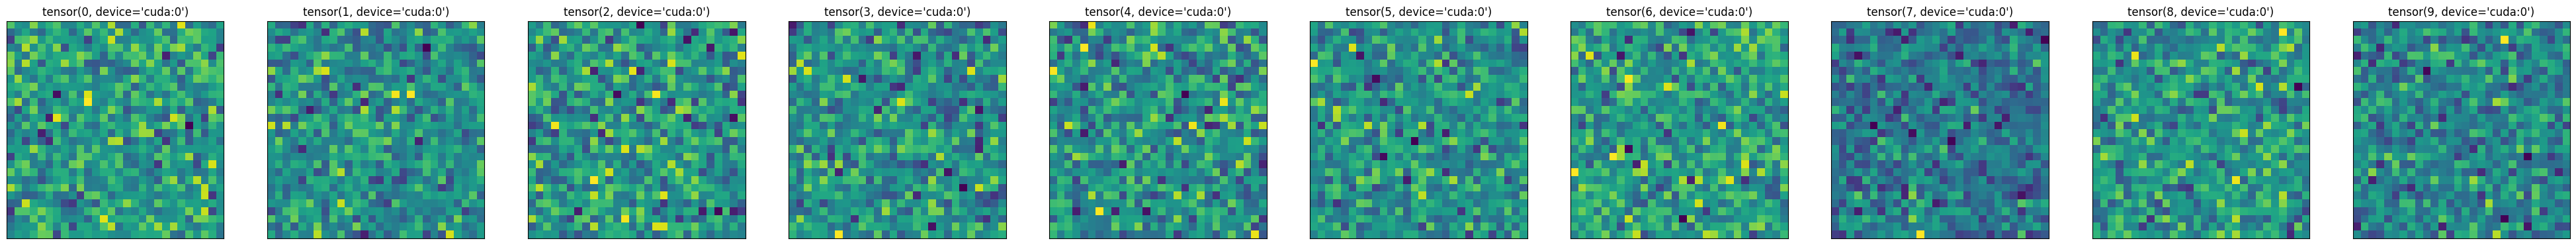

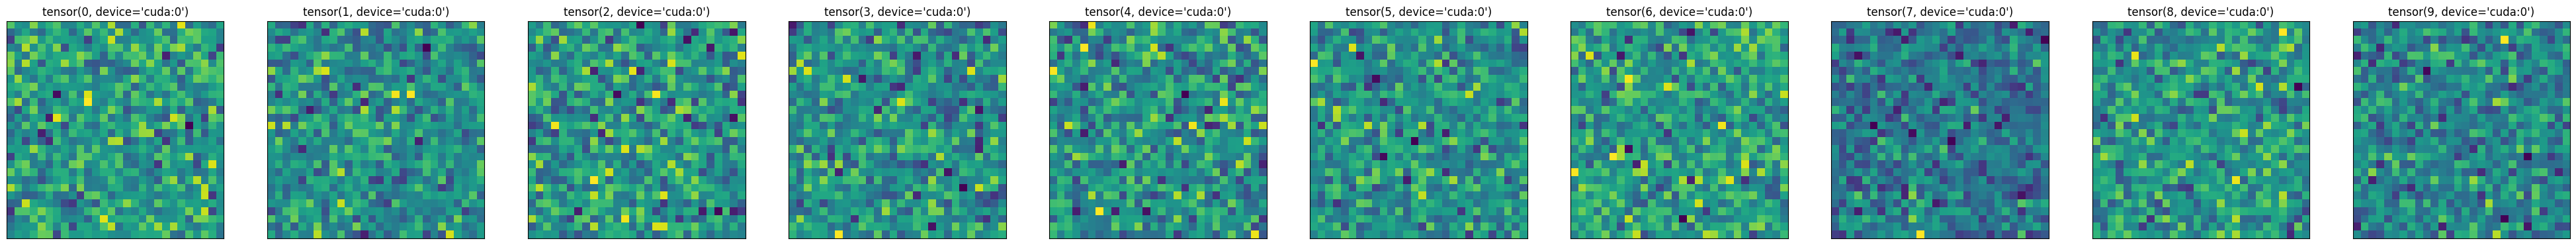

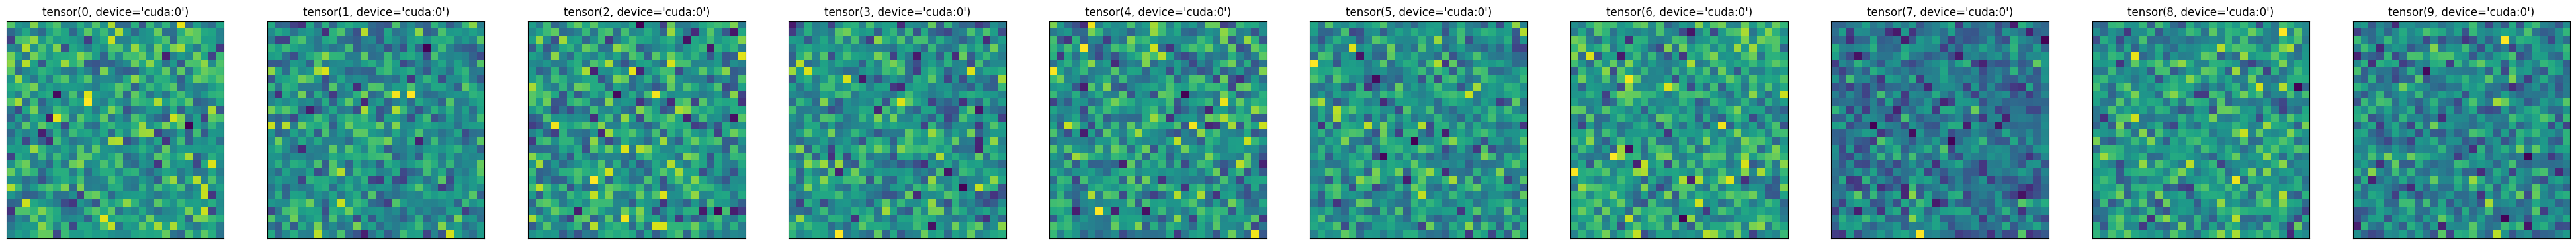

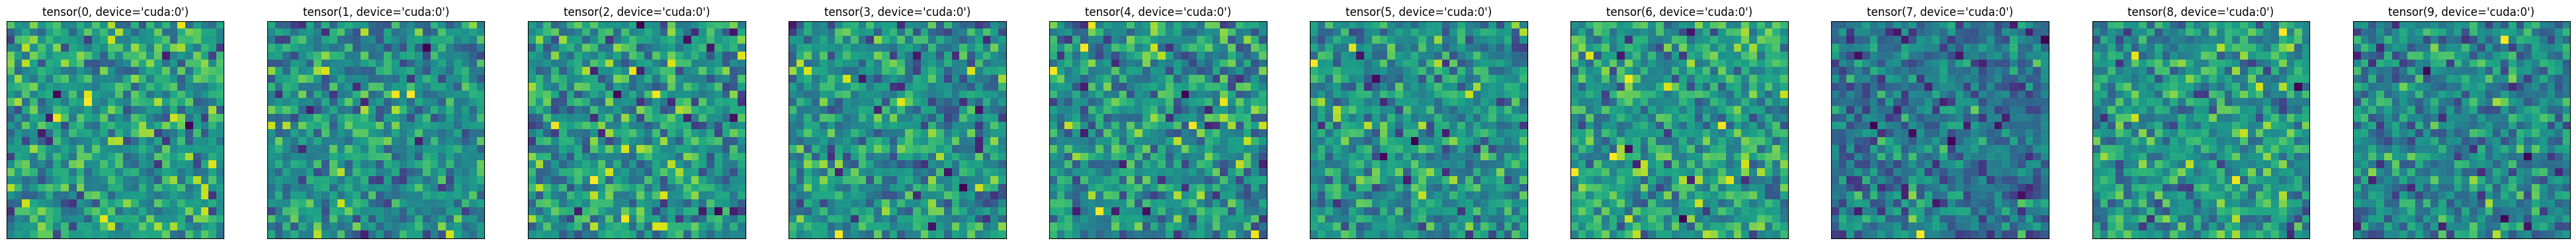

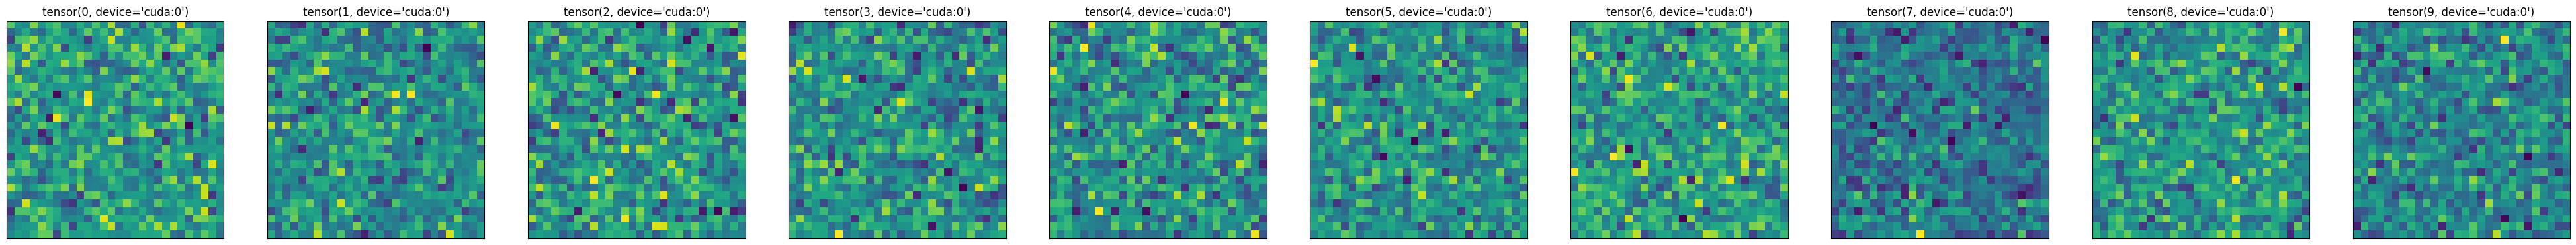

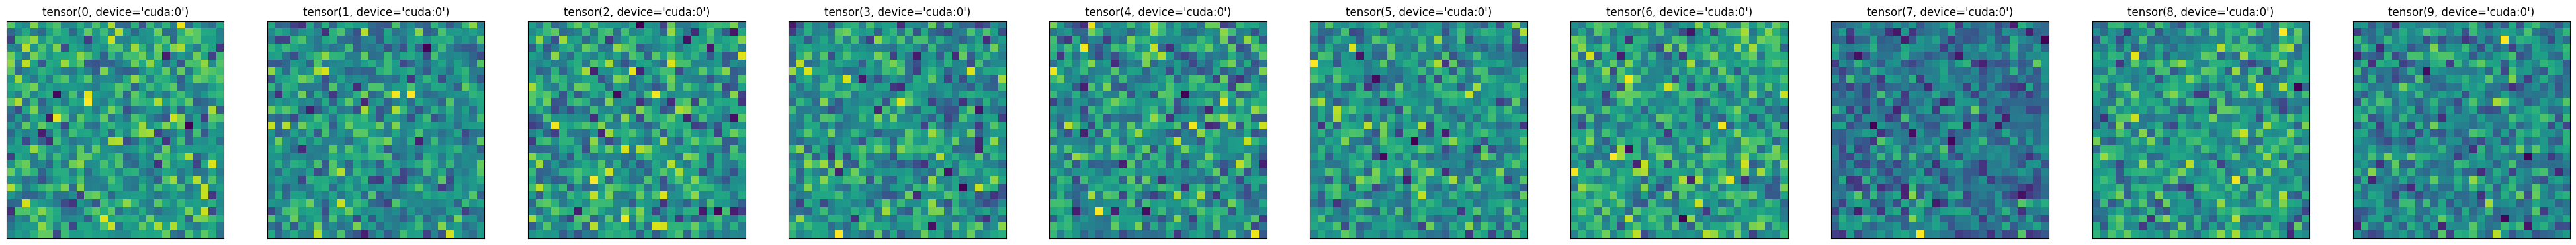

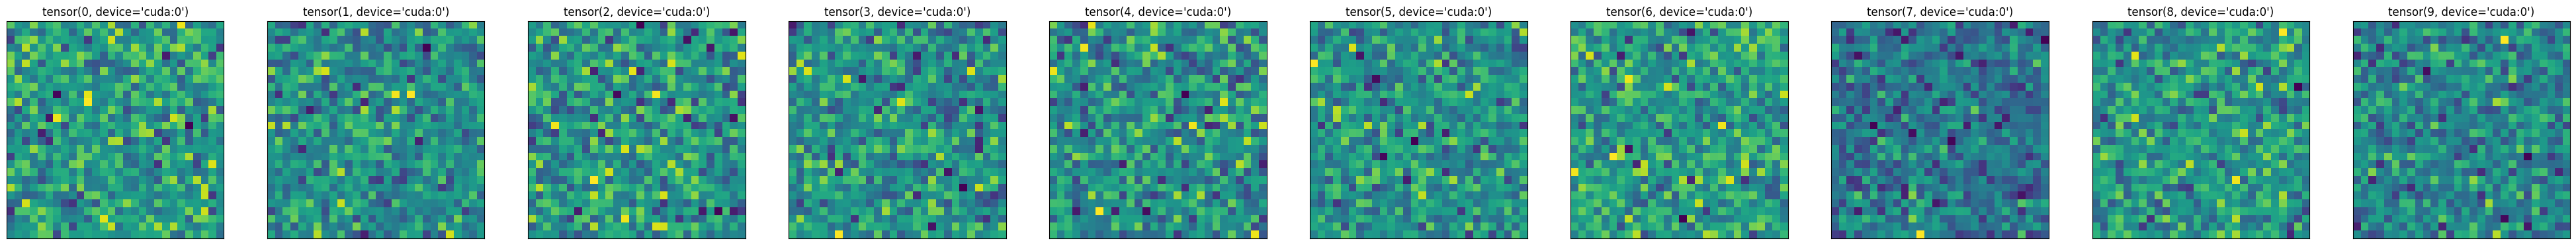

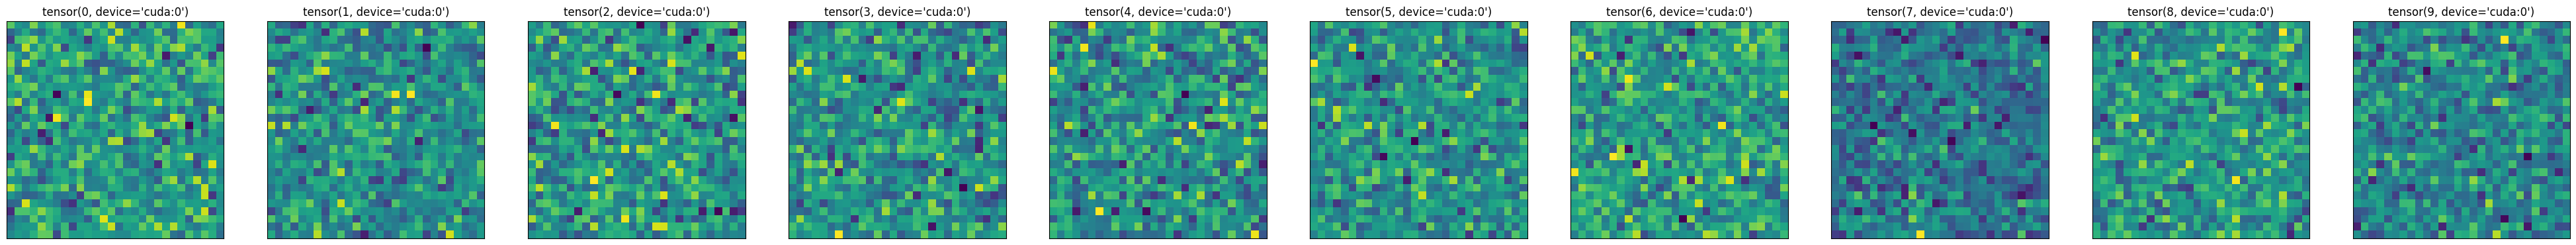

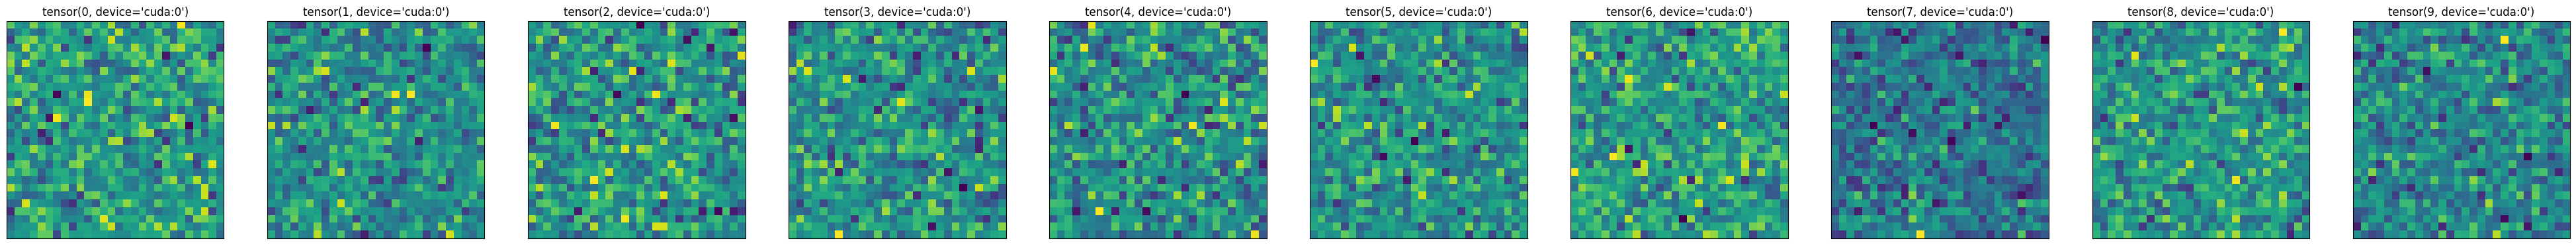

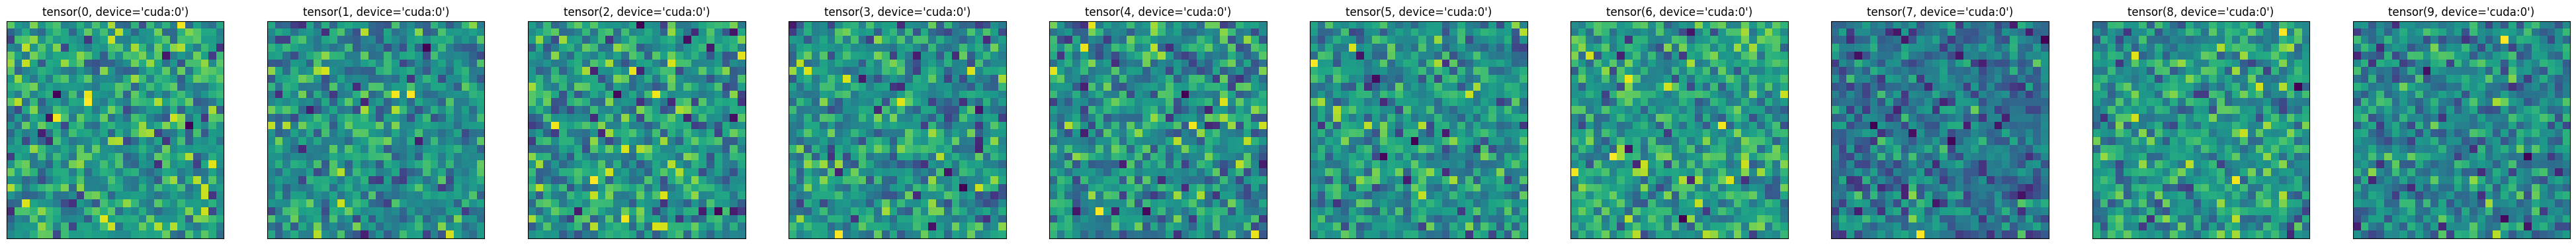

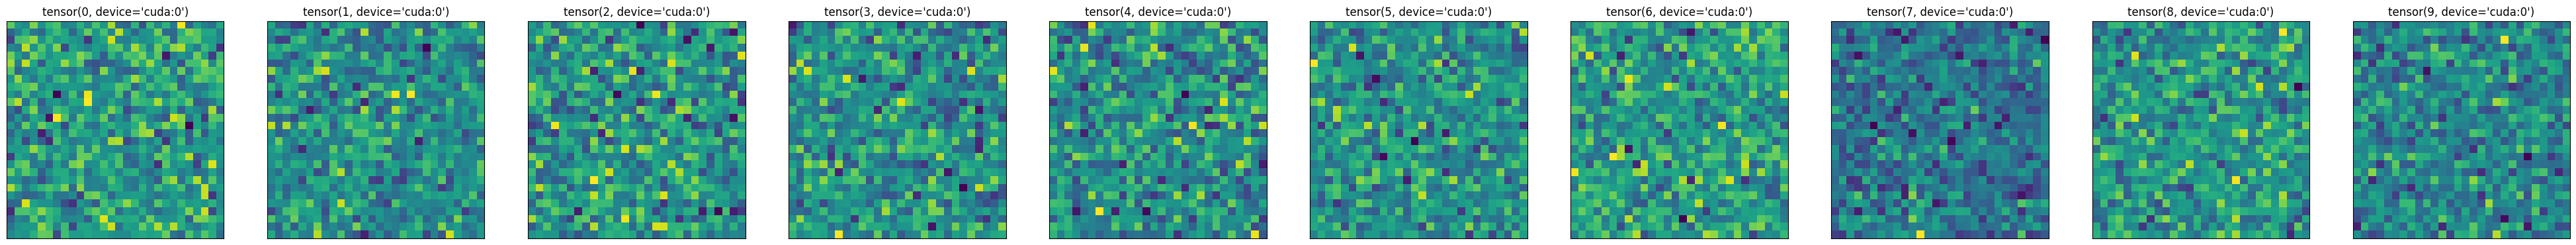

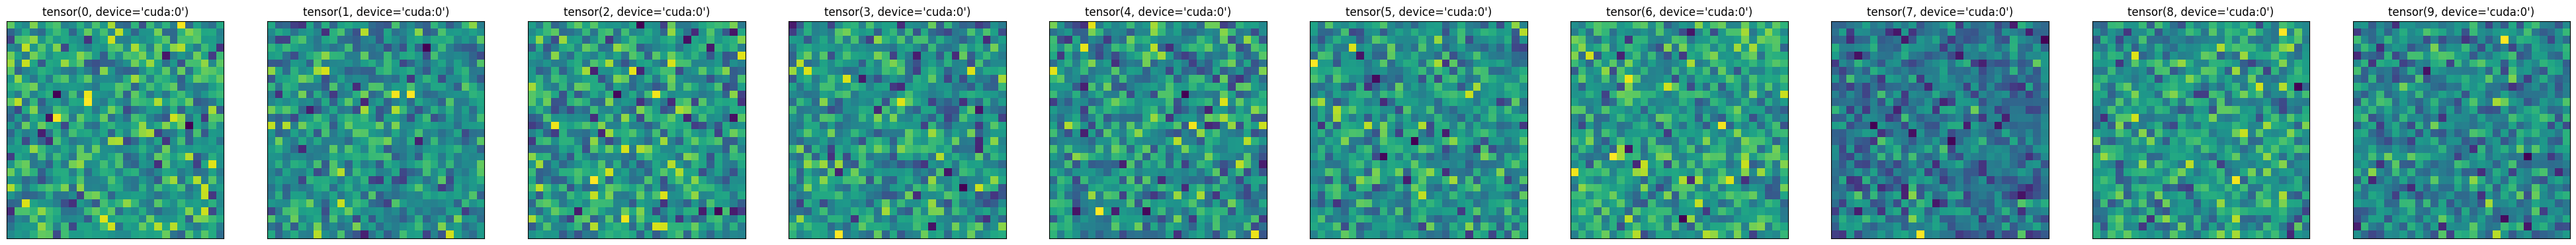

In [41]:
#Let's teach the noised_inputs to be well predicted
net.to(device)
net.requires_grad= False
labels=torch.tensor([0,1,2,3,4,5,6,7,8,9])
noised_inputs=torch.randn((10,1,28,28))
starting_inputs=noised_inputs.clone()
noised_inputs = noised_inputs.to(device)
noised_inputs.requires_grad = True
labels = labels.to(device)
optimizer = torch.optim.Adam([noised_inputs], 0.001)   #initial and fixed learning rate of 0.001.

accuracy=[]
for epoch in range(200):  #  an epoch is a training run through the whole data set

      optimizer.zero_grad()

      batch_outputs = net(noised_inputs)   #this line calls the forward(self, x) method of the MLP object. Please note, that the last layer of the MLP is linear
                                            #and MLP doesn't apply
                                            #the nonlinear activation after the last layer
      loss = torch.nn.functional.cross_entropy(batch_outputs, labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
      loss.backward()       #this computes gradients as we have seen in previous workshops
      optimizer.step()
      if epoch % 10 == 0:
        print("epoch:", epoch,  "current batch loss:", loss.item())
        display_numbers(noised_inputs.cpu().detach().numpy())

      good=0
      wrong=0
      with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
        for i in range(10): #batches in test are of size 1
          datapoint= noised_inputs[i]
          label = labels[i]

          prediction = net(datapoint.to(device))                  #prediction has values representing the "prevalence" of the corresponding class
          classification = torch.argmax(prediction)    #the class is the index of maximal "prevalence"

          if classification.item() == label.item():
            good += 1
          else:
            wrong += 1
      accuracy.append(good/(good+wrong))


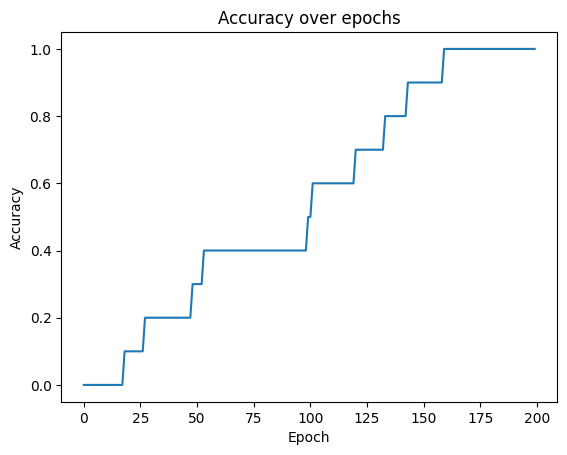

In [42]:
plt.plot(accuracy)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over epochs")
plt.show()

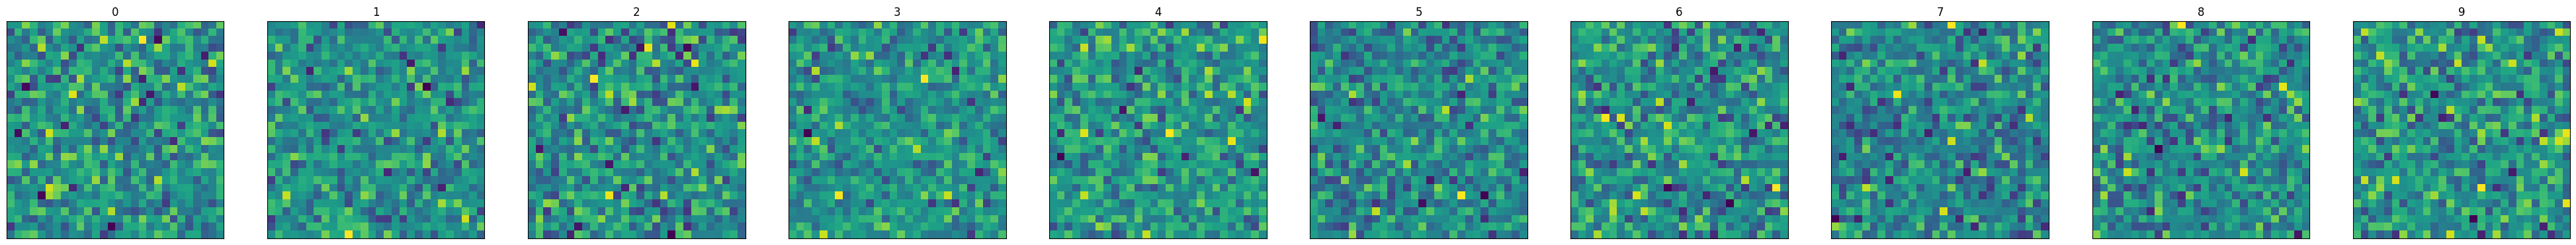

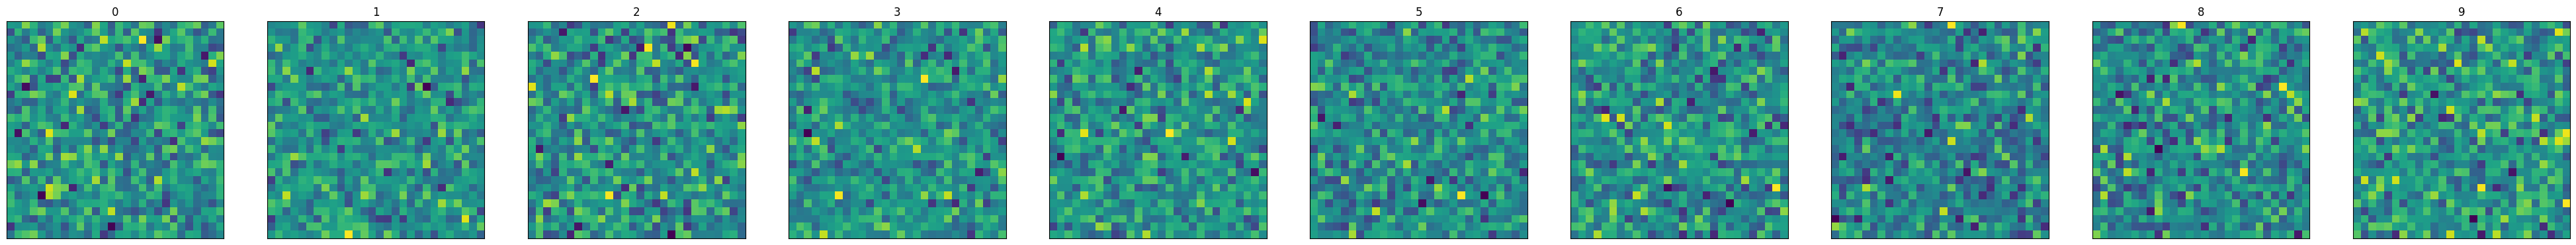

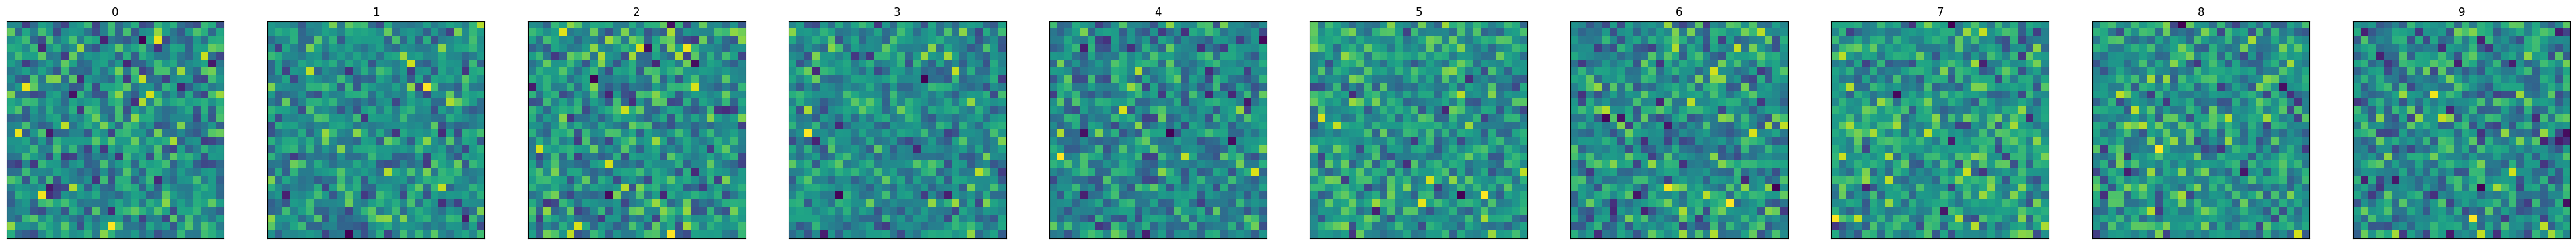

In [25]:
#Inputs before training
display_numbers(starting_inputs.cpu().detach().numpy())
#Inputs after training
display_numbers(noised_inputs.cpu().detach().numpy())
#Difference between them
display_numbers((noised_inputs.to(device)-starting_inputs.to(device)).cpu().detach().numpy())

I can't see much of the difference between starting inputs and inputs after training. However we can see that the model has 100% accuracy. This is because model doesn't learn how exactly digits look like, but how they look different from one another.

### Task 2

I would say there are to approaches to that:


1.   Create Loss that is the sum of losses from every label that we want to achieve
2.   Have the same starting picture to be



torch.Size([10])
epoch: 0 current batch loss: 9.815139770507812
epoch: 10 current batch loss: 8.842612266540527
epoch: 20 current batch loss: 7.939886093139648
epoch: 30 current batch loss: 7.113372325897217
epoch: 40 current batch loss: 6.358480453491211
epoch: 50 current batch loss: 5.68553352355957
epoch: 60 current batch loss: 5.08155632019043
epoch: 70 current batch loss: 4.552796363830566
epoch: 80 current batch loss: 4.088802814483643
epoch: 90 current batch loss: 3.6897740364074707
epoch: 100 current batch loss: 3.349123954772949
epoch: 110 current batch loss: 3.065080404281616
epoch: 120 current batch loss: 2.8273487091064453
epoch: 130 current batch loss: 2.6353635787963867
epoch: 140 current batch loss: 2.4836950302124023
epoch: 150 current batch loss: 2.364426612854004
epoch: 160 current batch loss: 2.26798939704895
epoch: 170 current batch loss: 2.187426805496216
epoch: 180 current batch loss: 2.1186683177948
epoch: 190 current batch loss: 2.0591750144958496


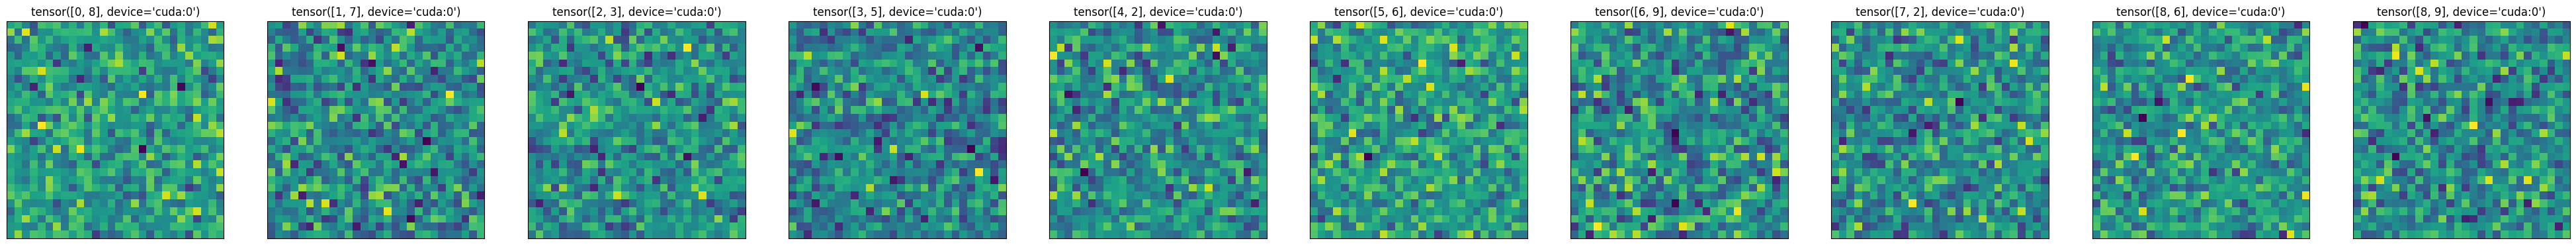

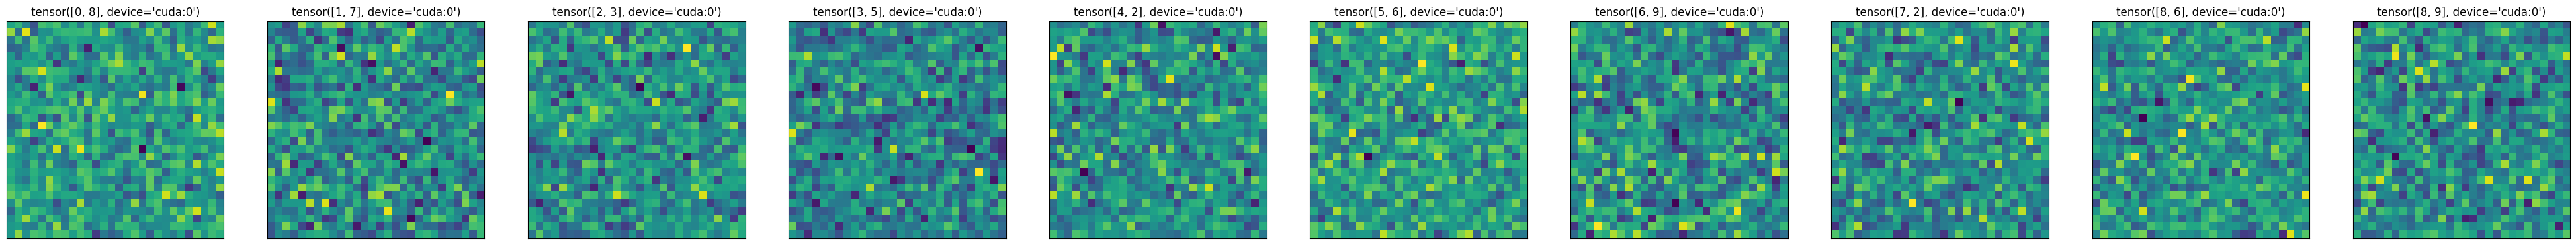

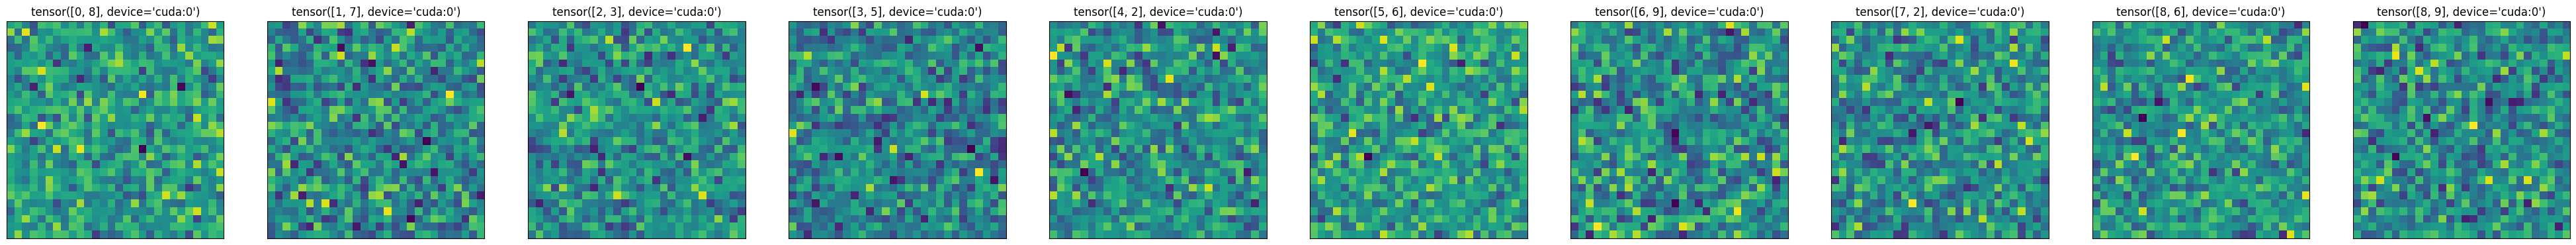

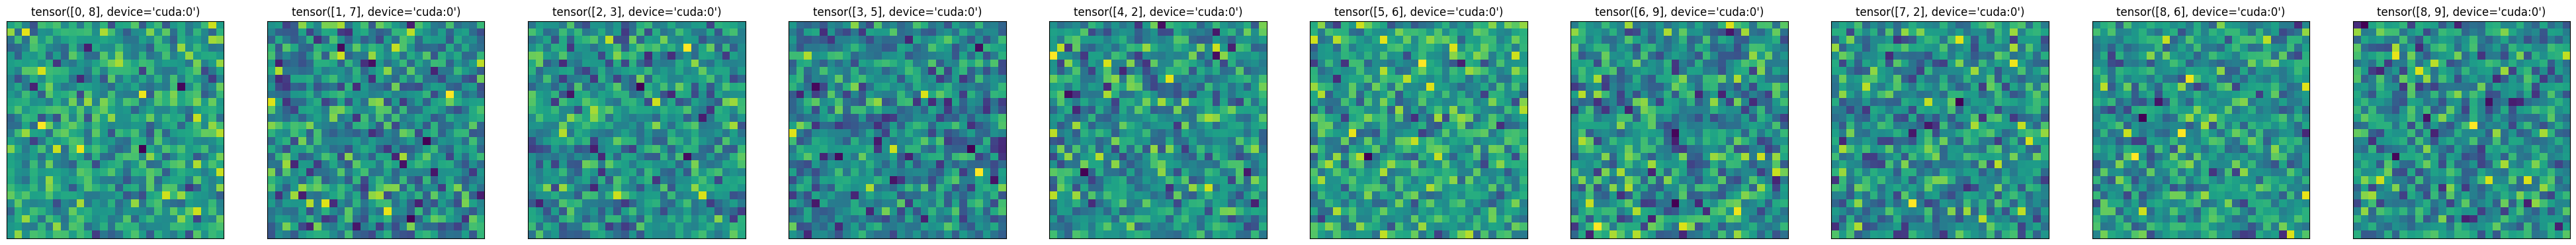

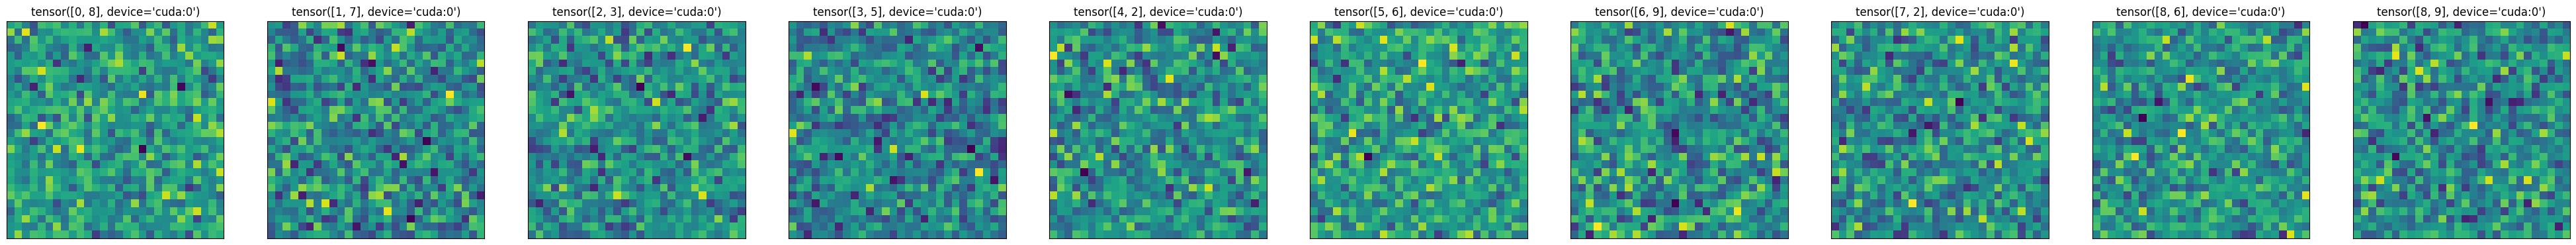

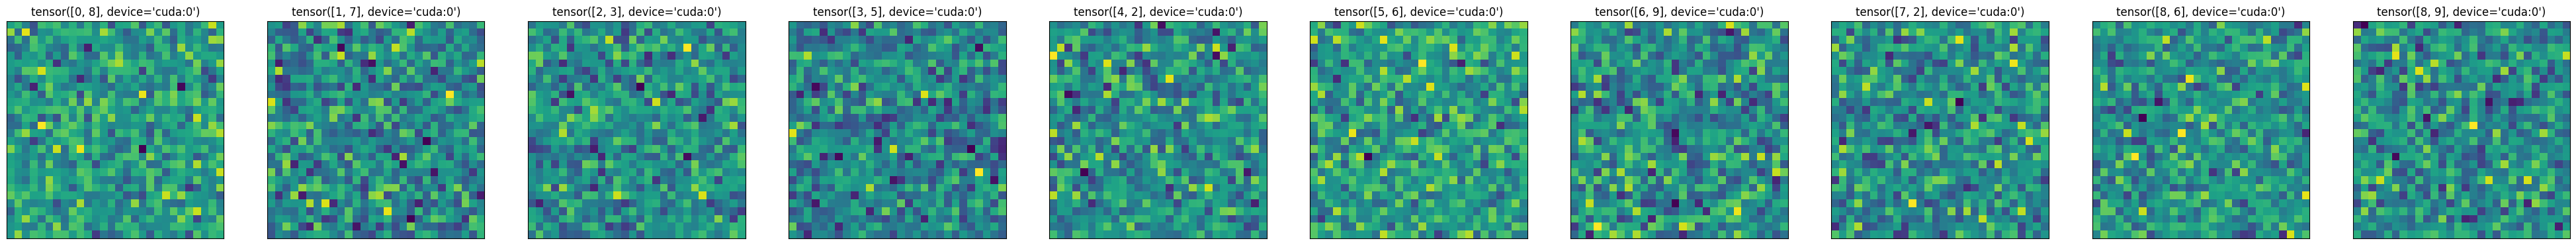

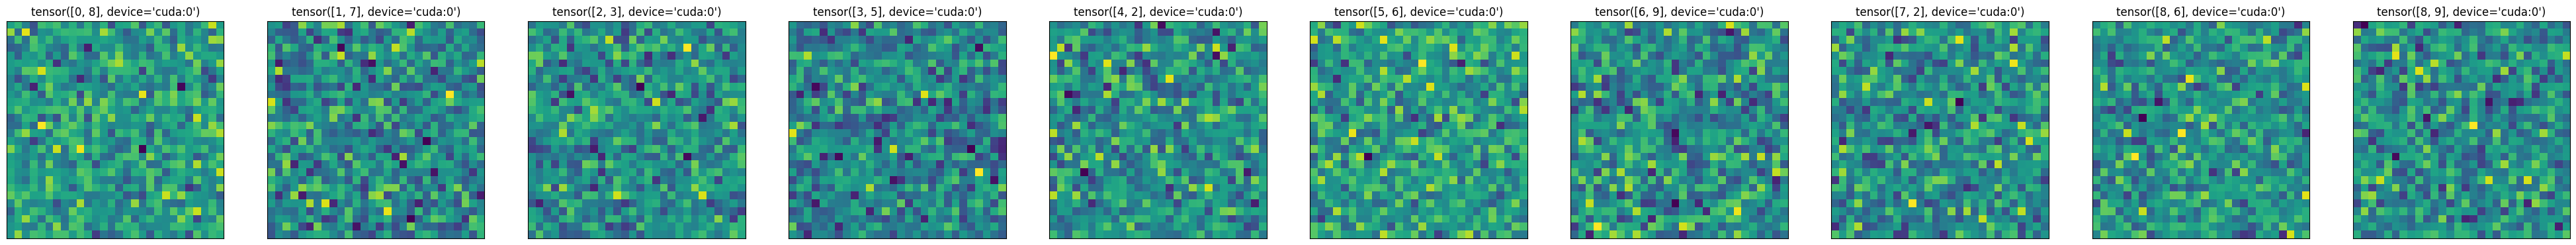

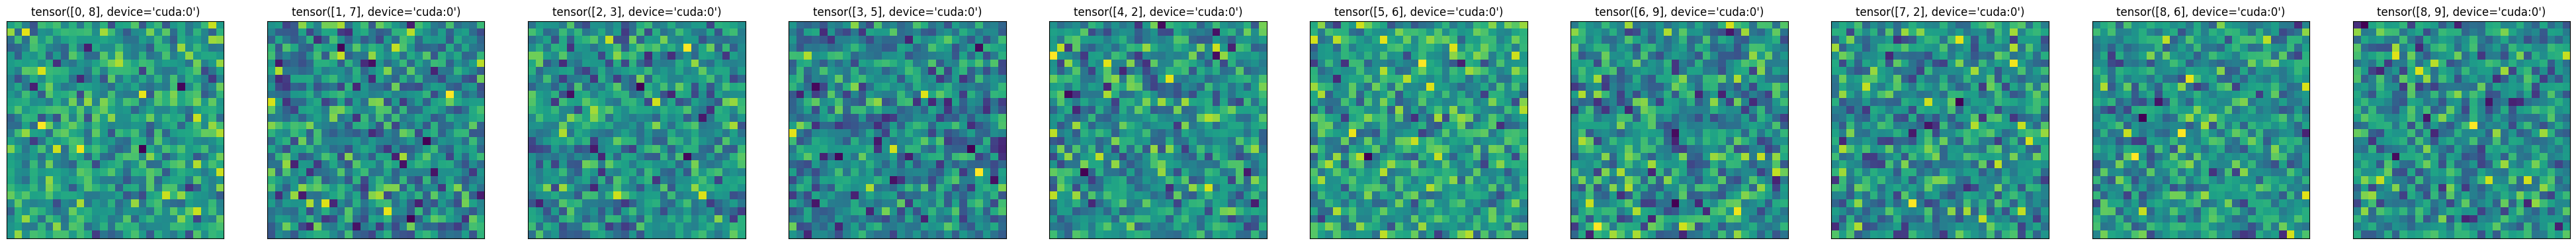

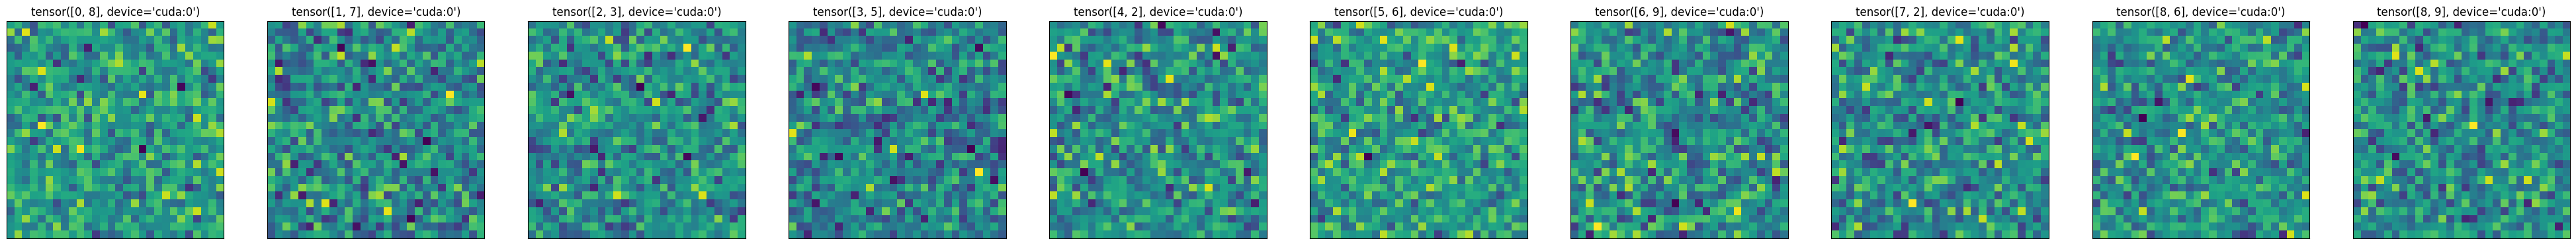

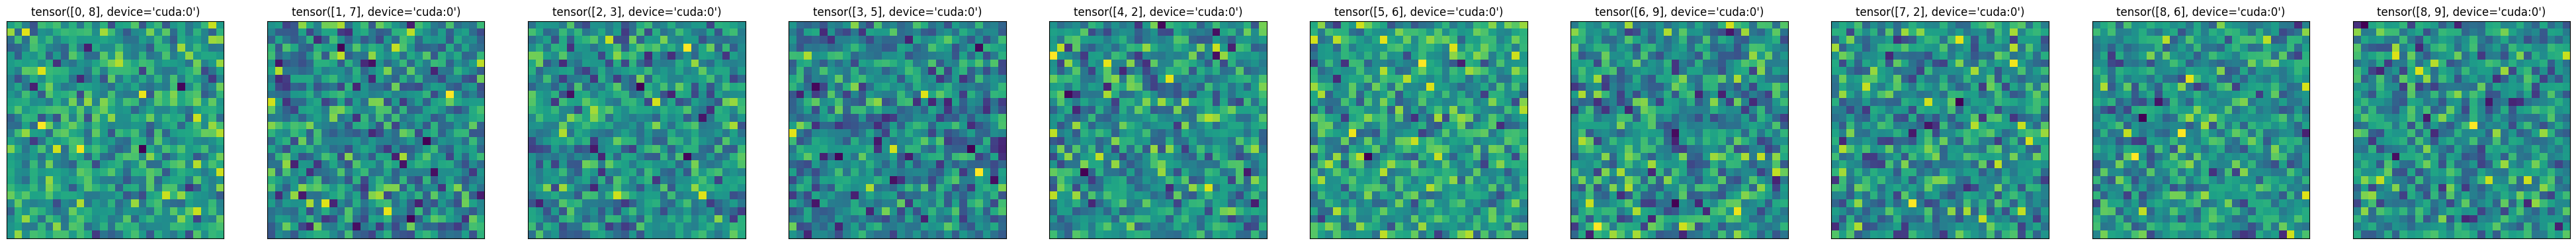

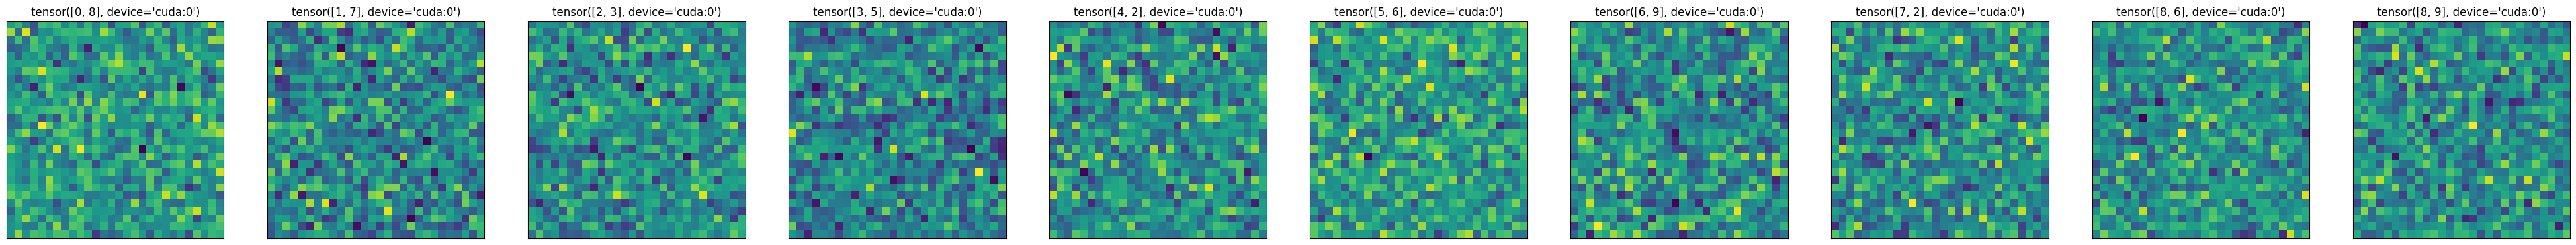

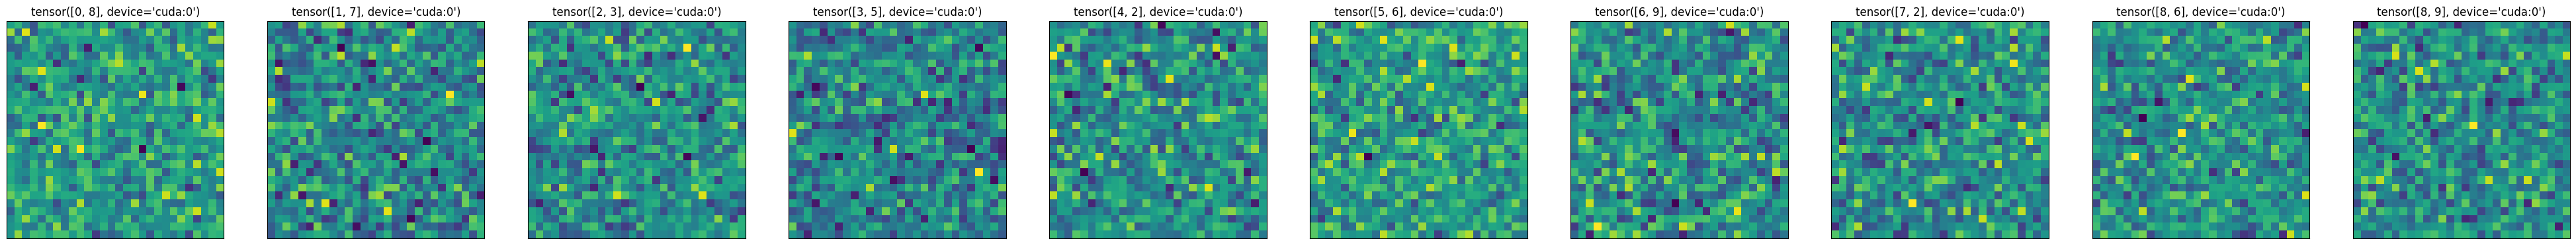

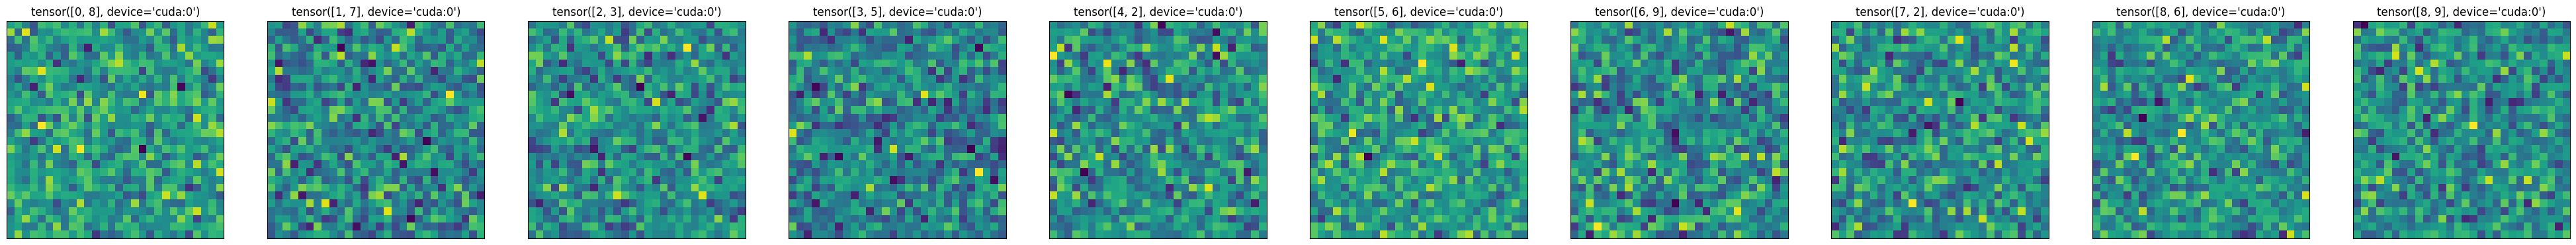

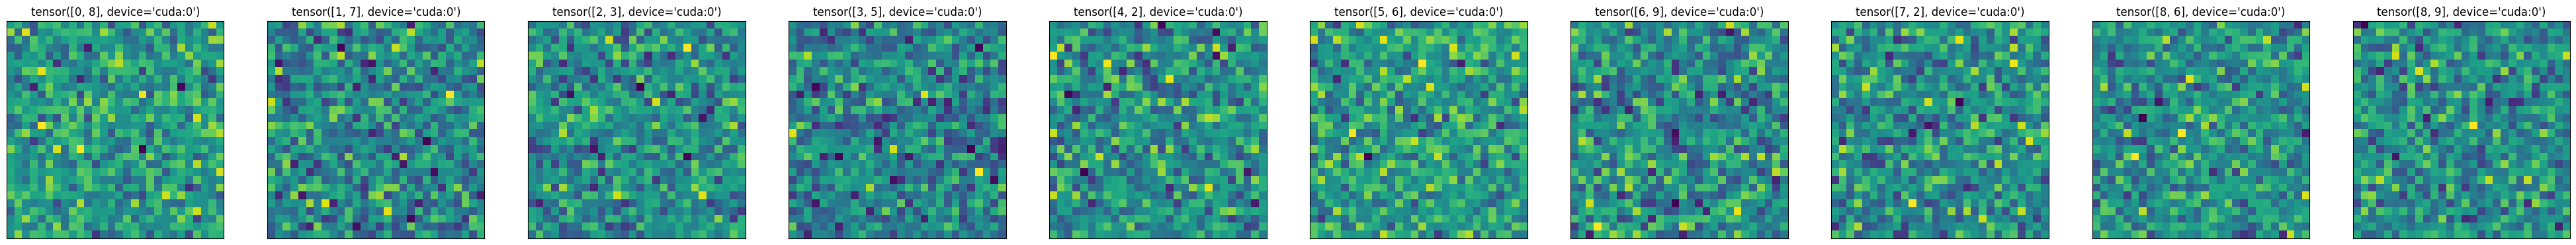

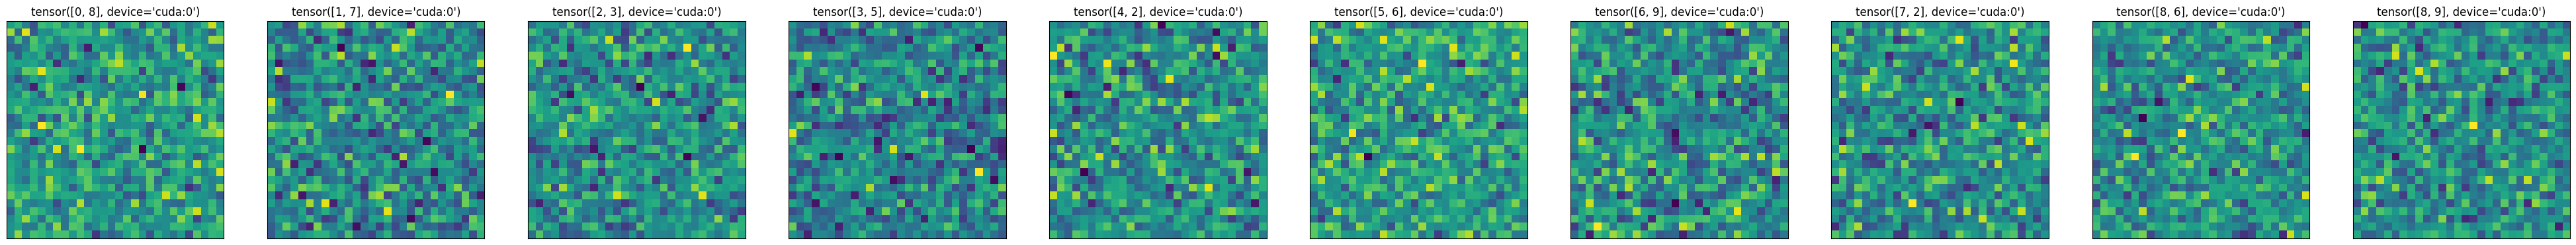

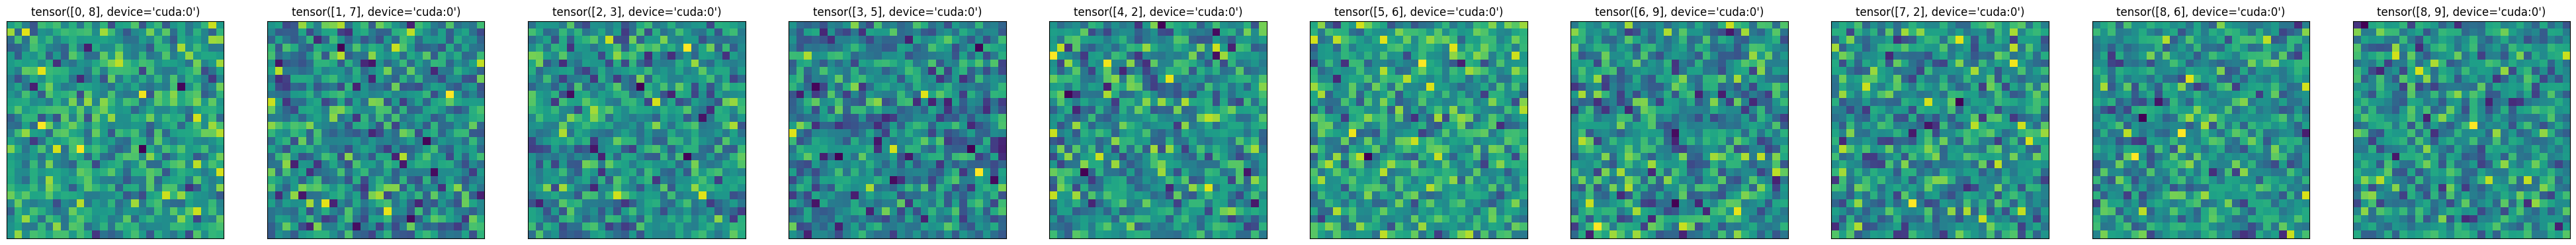

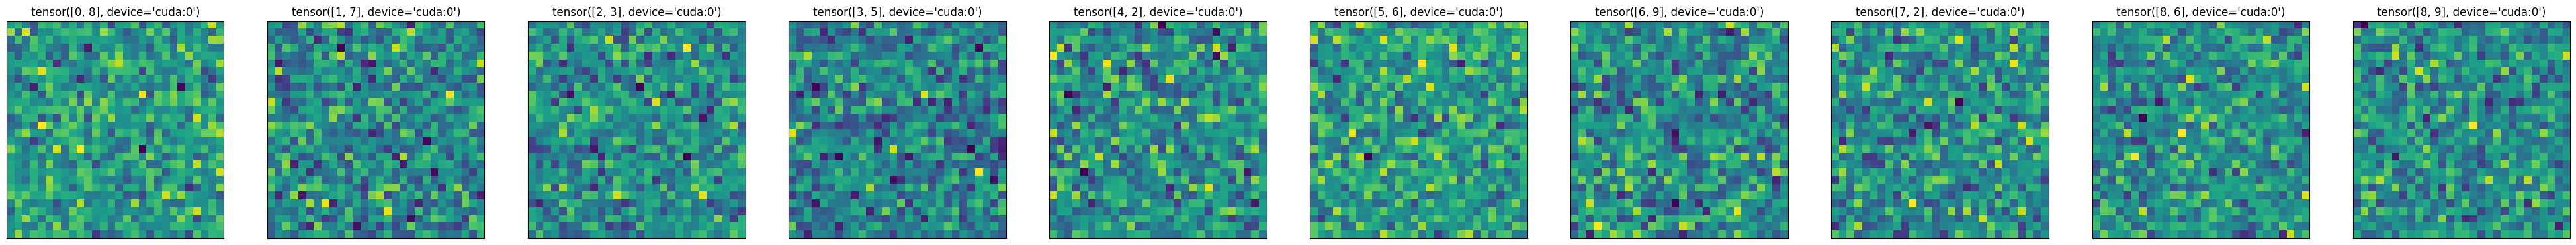

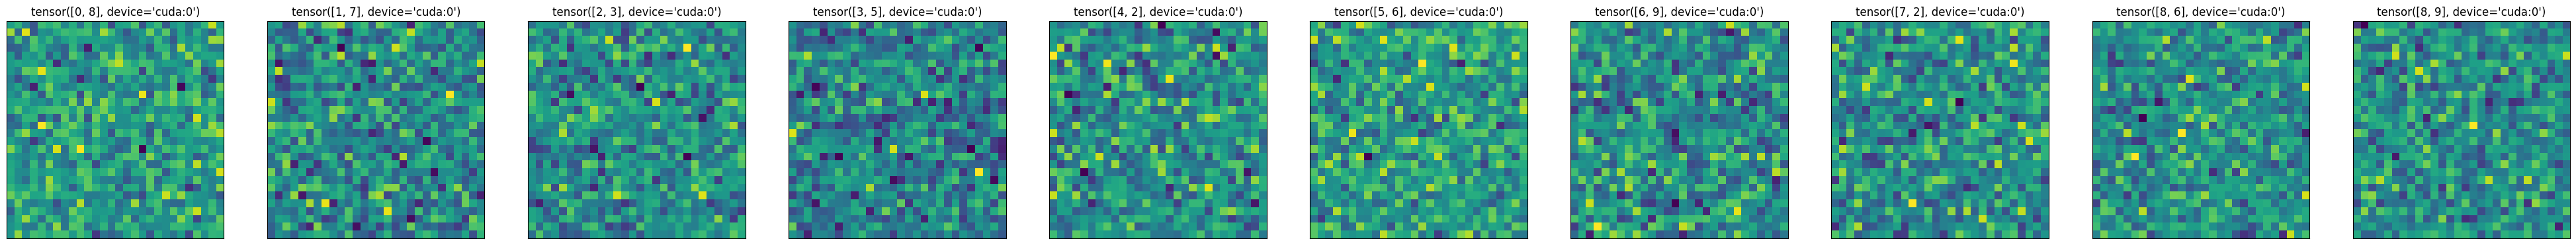

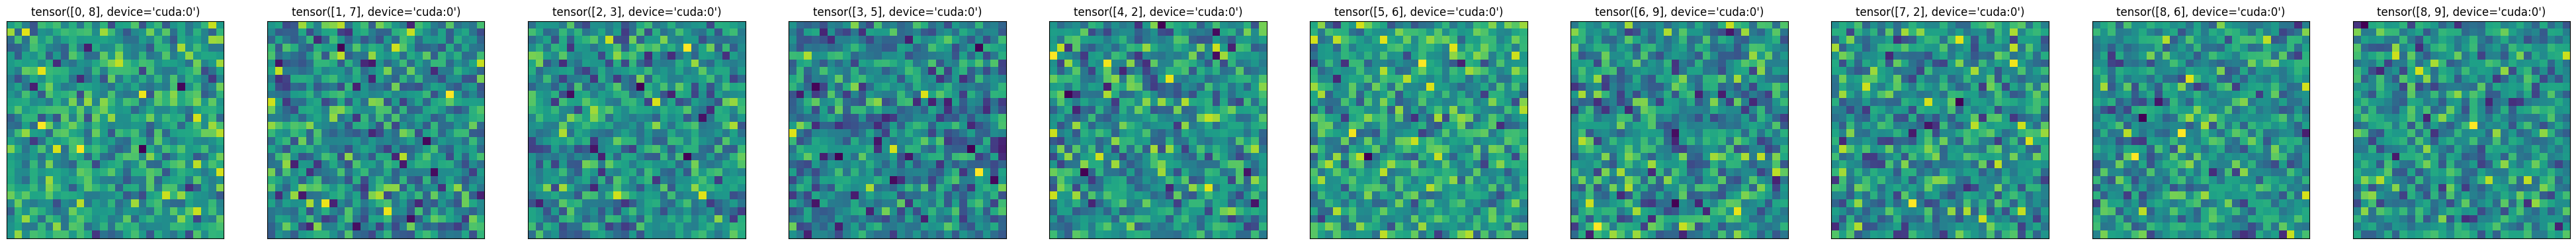

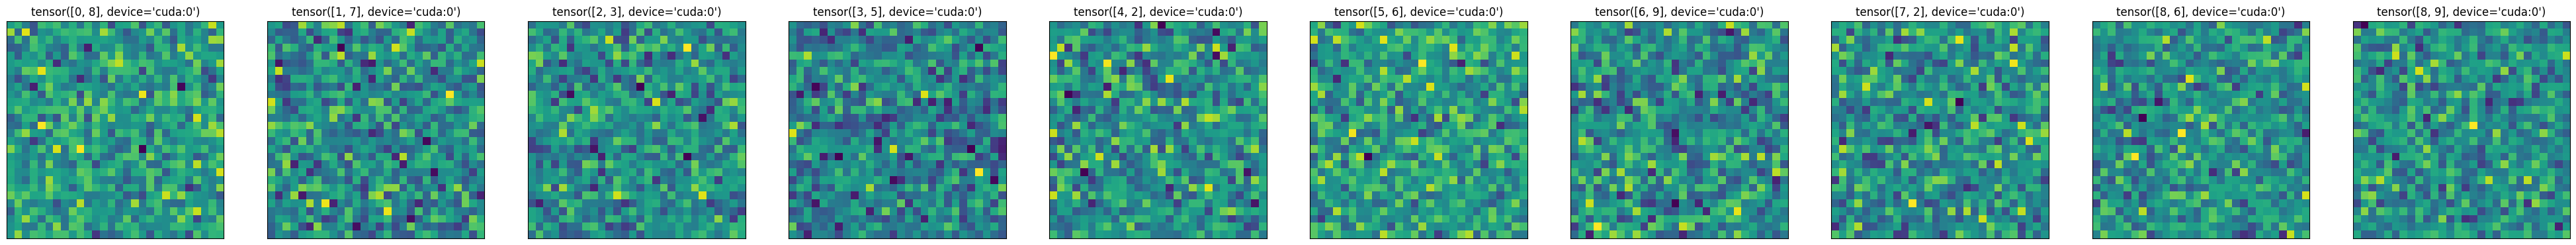

In [37]:
net.to(device)
net.requires_grad= False
labels=torch.tensor([[0,8],[1,7],[2,3],[3,5],[4,2],[5,6],[6,9],[7,2],[8,6],[8,9]])
noised_inputs=torch.randn((10,1,28,28))
starting_inputs=noised_inputs.clone()
noised_inputs = noised_inputs.to(device)
noised_inputs.requires_grad = True
labels = labels.to(device)
optimizer = torch.optim.Adam([noised_inputs], 0.001)   #initial and fixed learning rate of 0.001.

accuracy = []

for epoch in range(200):  #  an epoch is a training run through the whole data set

      optimizer.zero_grad()

      batch_outputs = net(noised_inputs)   #this line calls the forward(self, x) method of the MLP object. Please note, that the last layer of the MLP is linear
                                            #and MLP doesn't apply
                                            #the nonlinear activation after the last layer
      loss = torch.nn.functional.cross_entropy(batch_outputs, labels[:,0],reduction = "mean")+torch.nn.functional.cross_entropy(batch_outputs, labels[:,1],reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
      loss.backward()       #this computes gradients as we have seen in previous workshops
      optimizer.step()
      if epoch % 10 == 0:
        print("epoch:", epoch,  "current batch loss:", loss.item())
        display_numbers(noised_inputs.cpu().detach().numpy())

      good=0
      wrong=0
      with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
        for i in range(10): #batches in test are of size 1
          datapoint= noised_inputs[i]
          label = labels[i]

          prediction = net(datapoint.to(device))                  #prediction has values representing the "prevalence" of the corresponding class
          classification = torch.argmax(prediction)    #the class is the index of maximal "prevalence"

          if classification.item() in label:
            good += 1
          else:
            wrong += 1
      accuracy.append(good/(good+wrong))

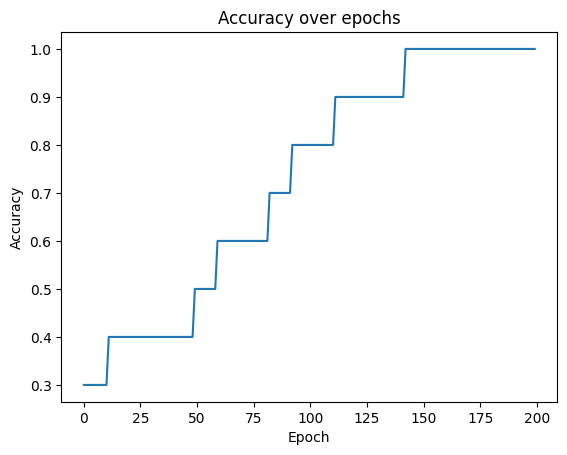

In [38]:
plt.plot(accuracy)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Accuracy over epochs')
plt.show()

### TASK 3.1



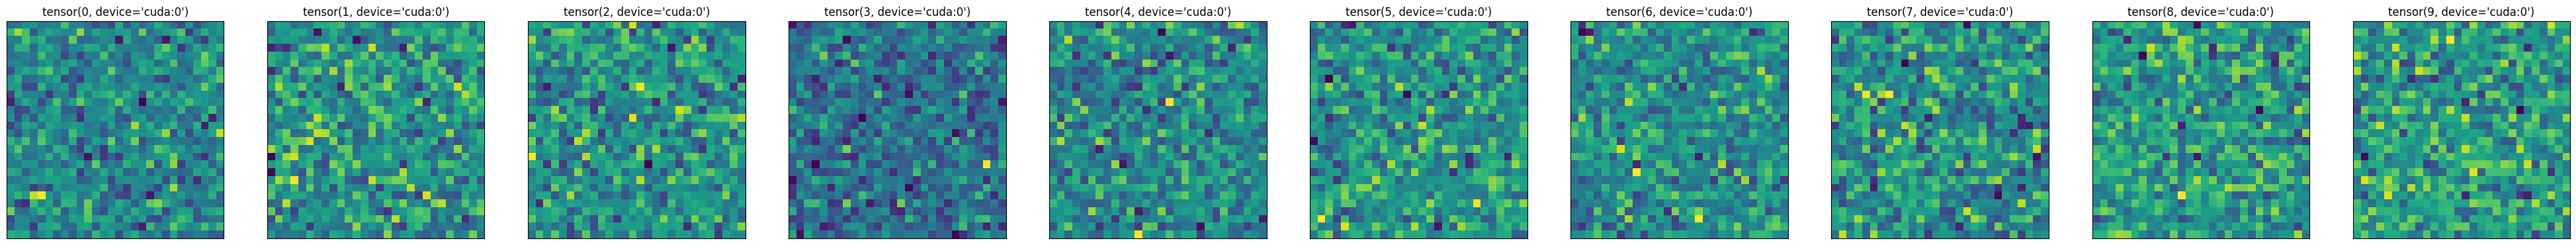

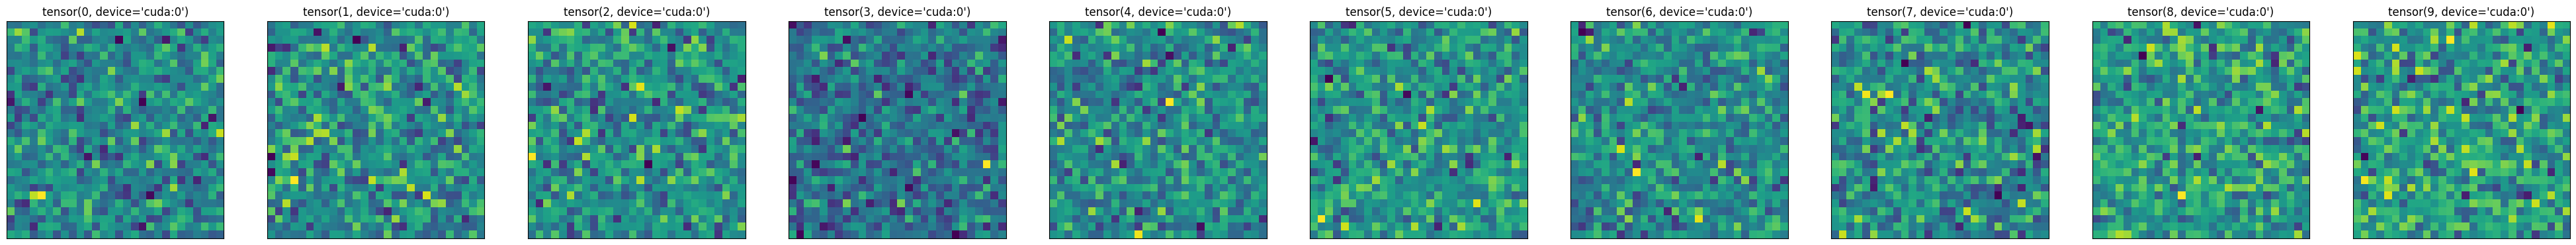

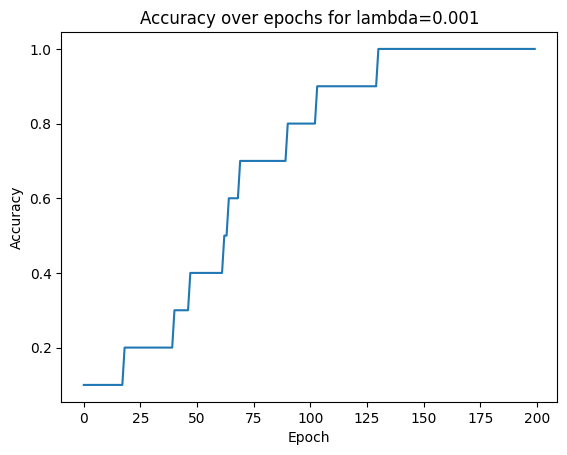

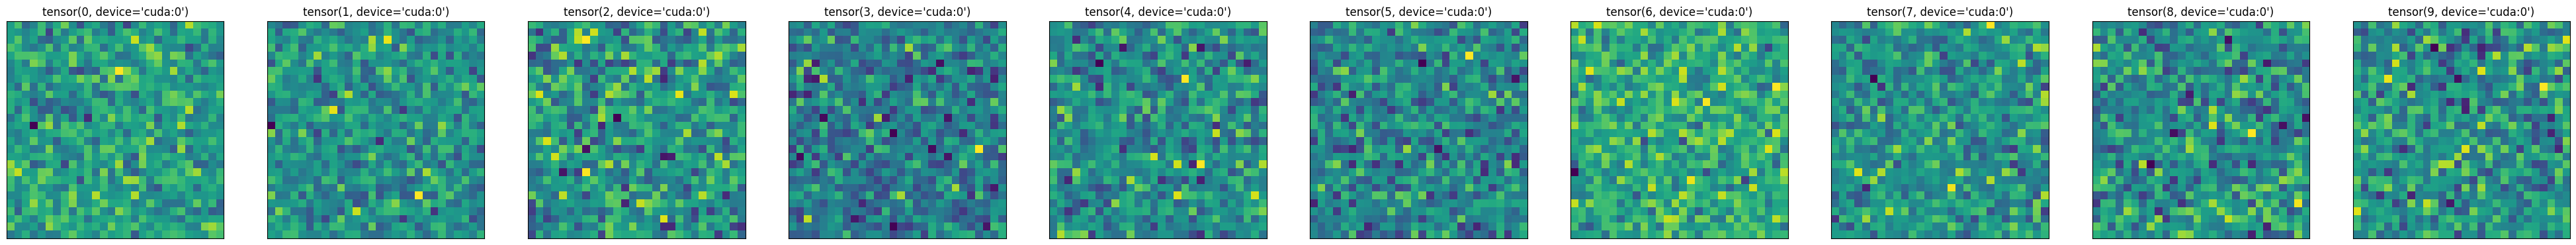

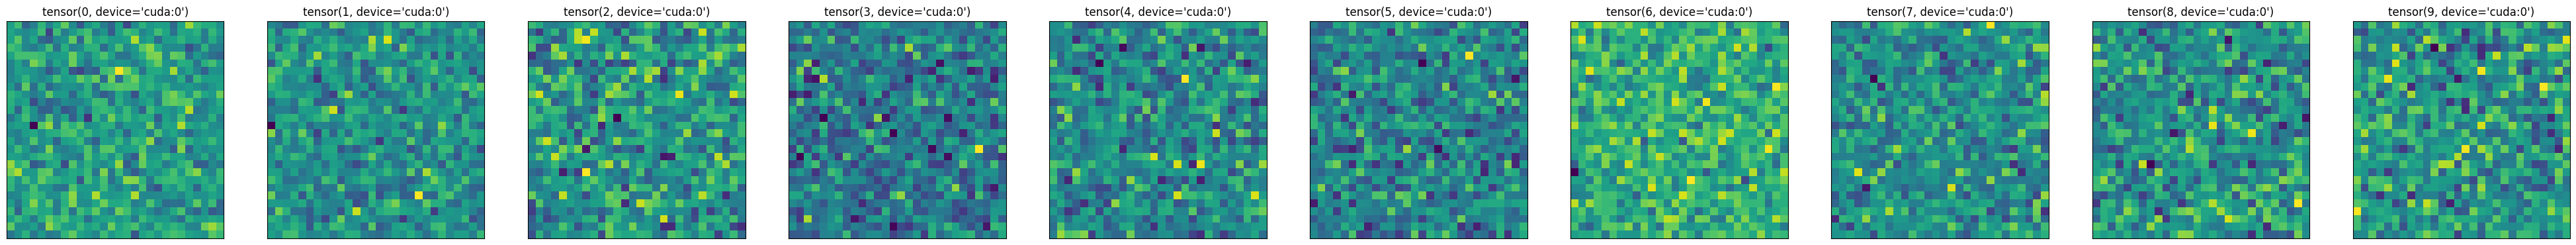

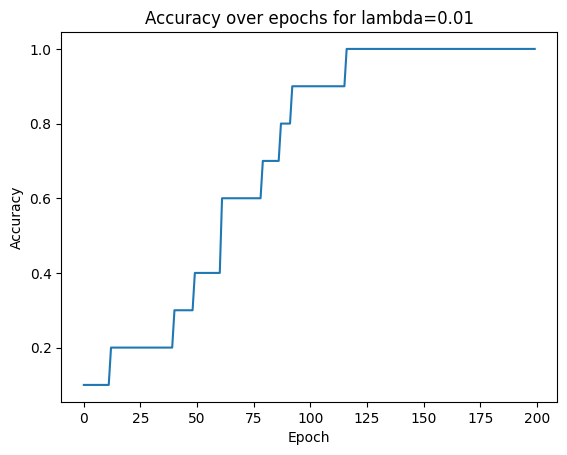

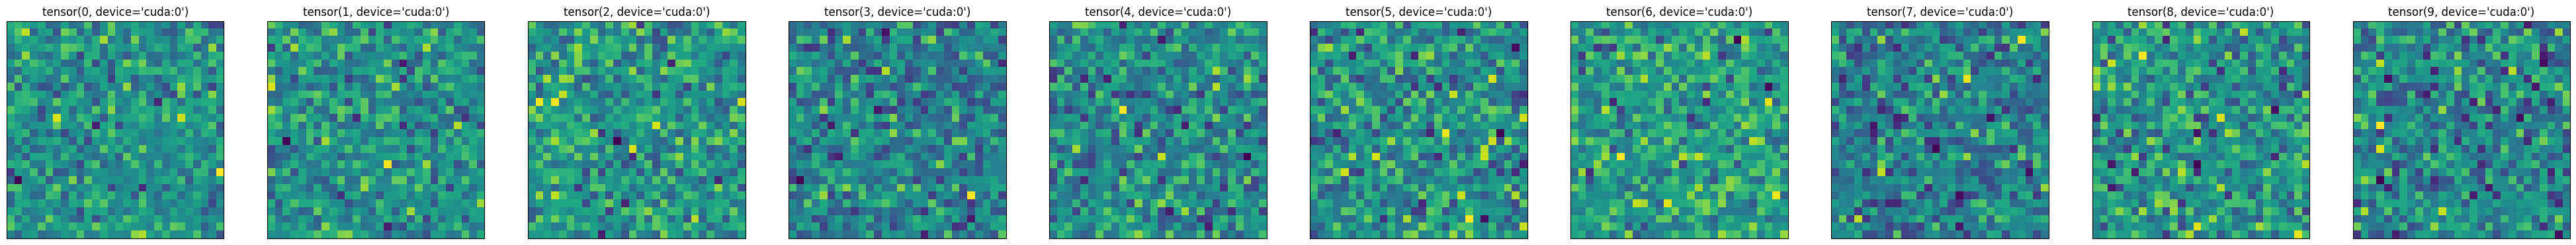

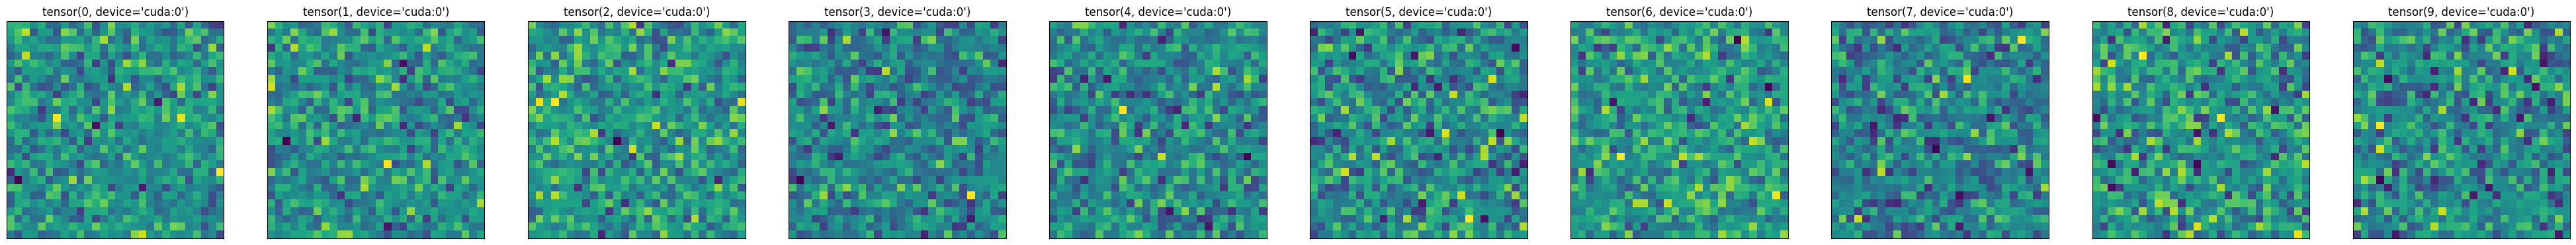

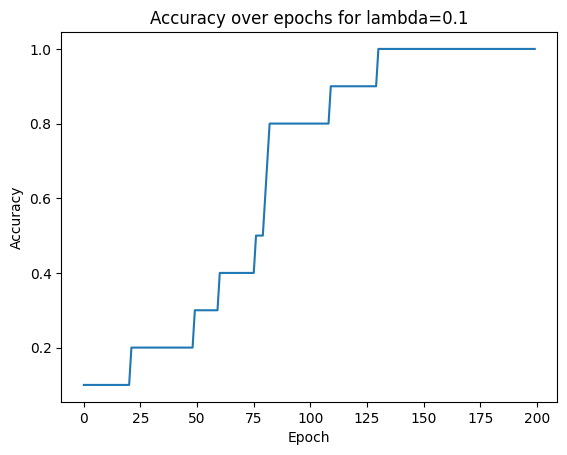

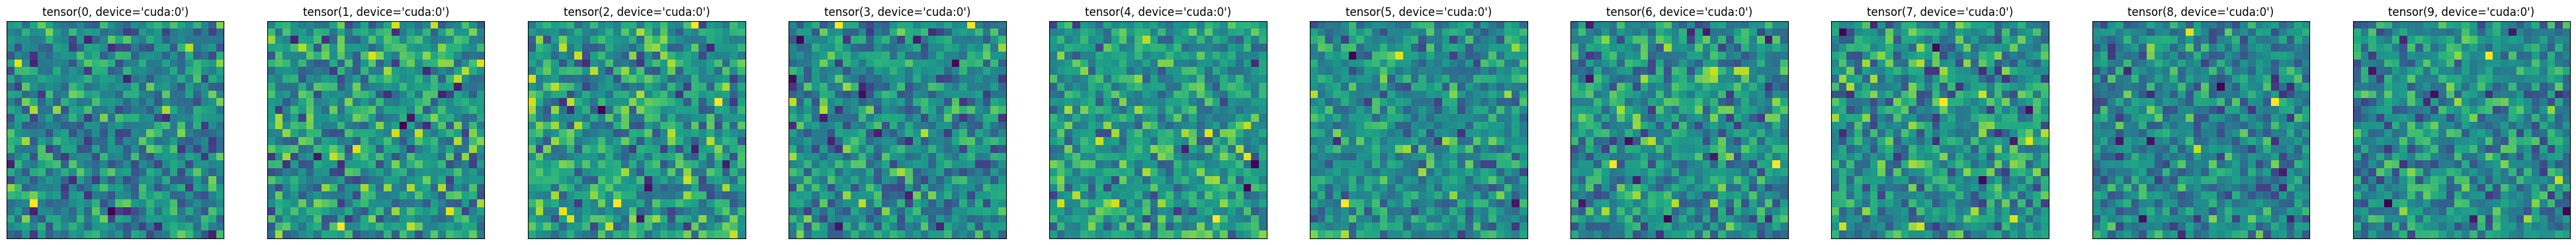

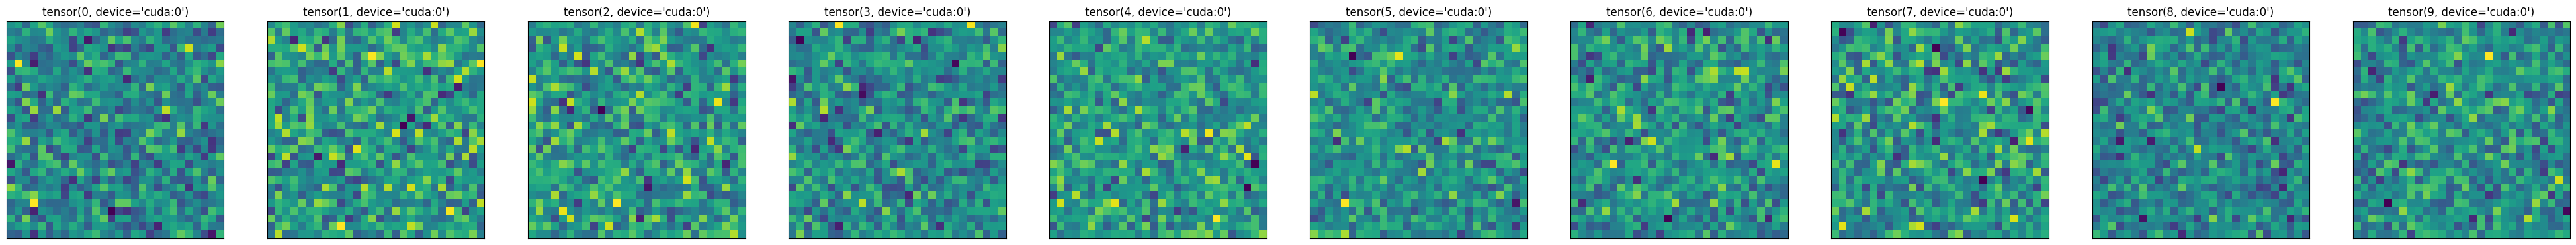

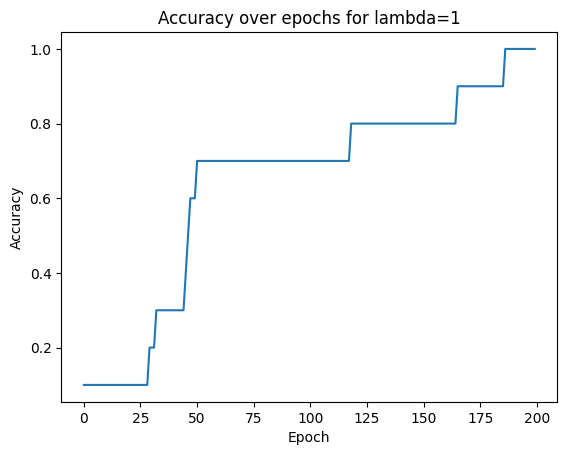

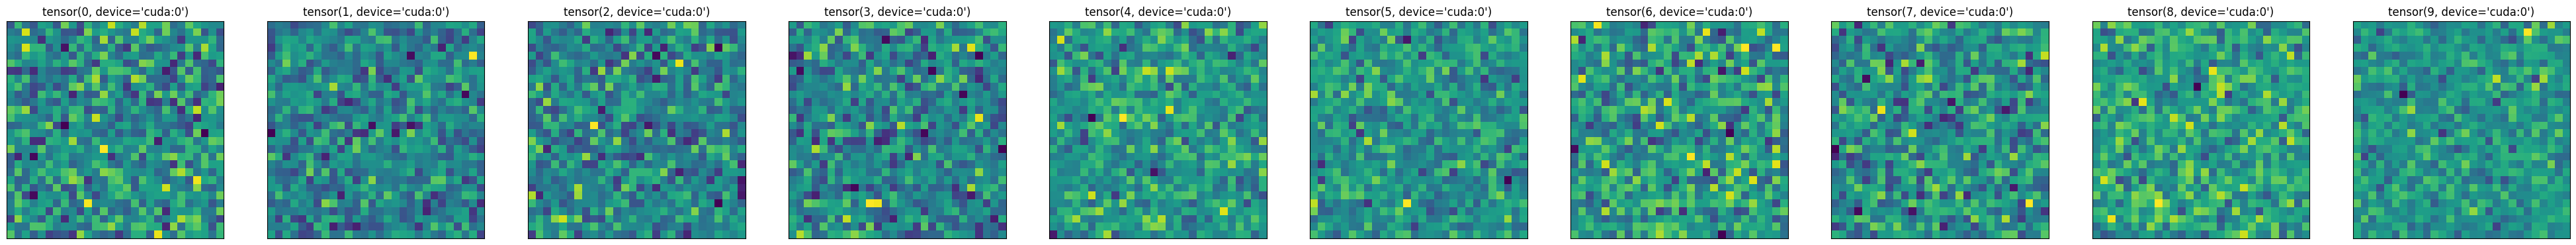

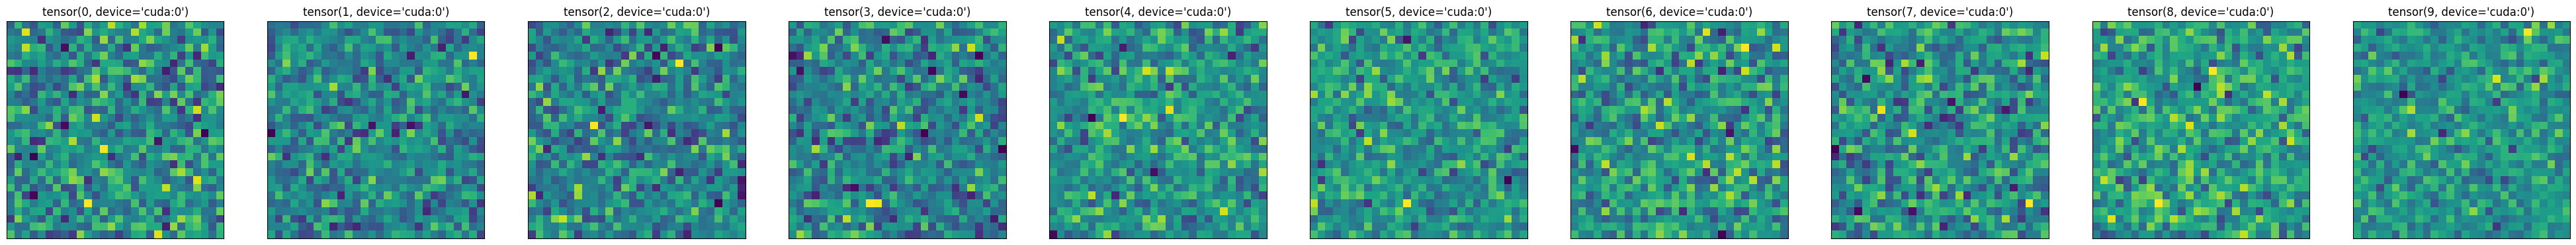

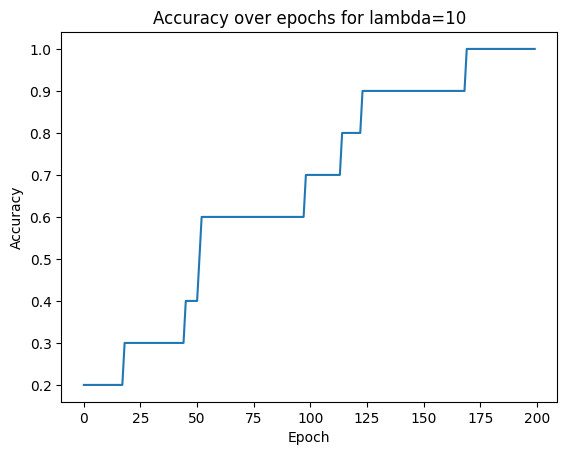

In [47]:
net.to(device)
net.requires_grad= False
labels=torch.tensor([0,1,2,3,4,5,6,7,8,9])

lambdas_l2=[0.001,0.01,0.1,1,10]

for lambda_l2 in lambdas_l2:

  noised_inputs=torch.randn((10,1,28,28))
  starting_inputs=noised_inputs.clone()
  noised_inputs = noised_inputs.to(device)
  noised_inputs.requires_grad = True
  labels = labels.to(device)
  optimizer = torch.optim.Adam([noised_inputs], 0.001)   #initial and fixed learning rate of 0.001.


  accuracy=[]

  display_numbers(starting_inputs.cpu().detach().numpy())

  for epoch in range(200):  #  an epoch is a training run through the whole data set

      optimizer.zero_grad()

      batch_outputs = net(noised_inputs)   #this line calls the forward(self, x) method of the MLP object. Please note, that the last layer of the MLP is linear
                                            #and MLP doesn't apply
                                            #the nonlinear activation after the last layer
      loss = torch.nn.functional.cross_entropy(batch_outputs, labels, reduction = "mean")+lambda_l2 * noised_inputs.pow(2).mean() #instead, nonlinear softmax is applied internally in THIS loss function
      loss.backward()       #this computes gradients as we have seen in previous workshops
      optimizer.step()

      good=0
      wrong=0
      with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
        for i in range(10): #batches in test are of size 1
          datapoint= noised_inputs[i]
          label = labels[i]

          prediction = net(datapoint.to(device))                  #prediction has values representing the "prevalence" of the corresponding class
          classification = torch.argmax(prediction)    #the class is the index of maximal "prevalence"

          if classification.item() == label.item():
            good += 1
          else:
            wrong += 1
      accuracy.append(good/(good+wrong))
  display_numbers(noised_inputs.cpu().detach().numpy())
  plt.show()
  plt.plot(accuracy)
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.title(f'Accuracy over epochs for lambda={lambda_l2}')
  plt.show()



Even thou we added ridge penalty it didn't help to visualize real numbers.

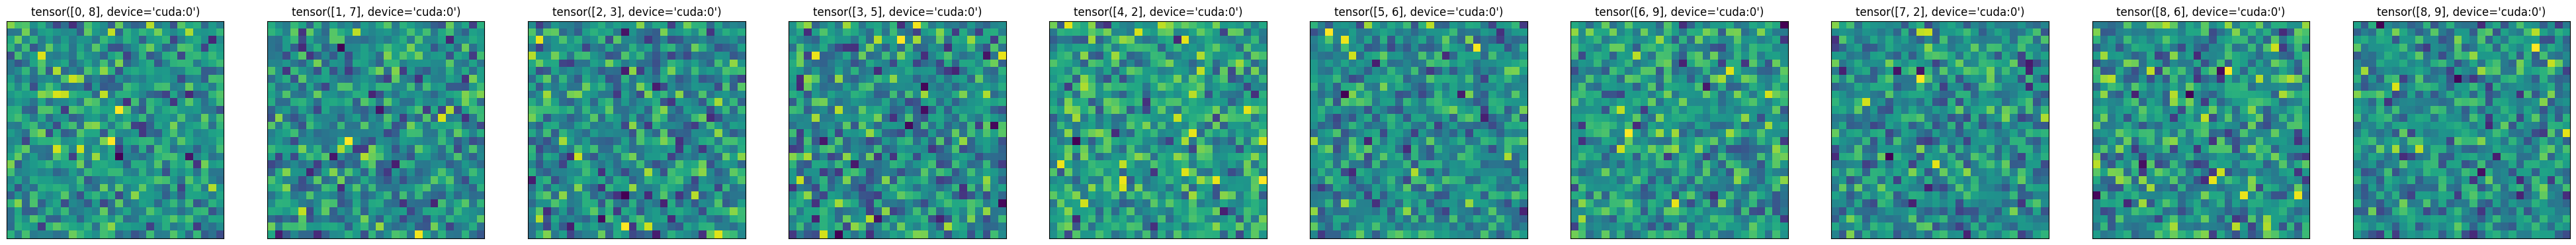

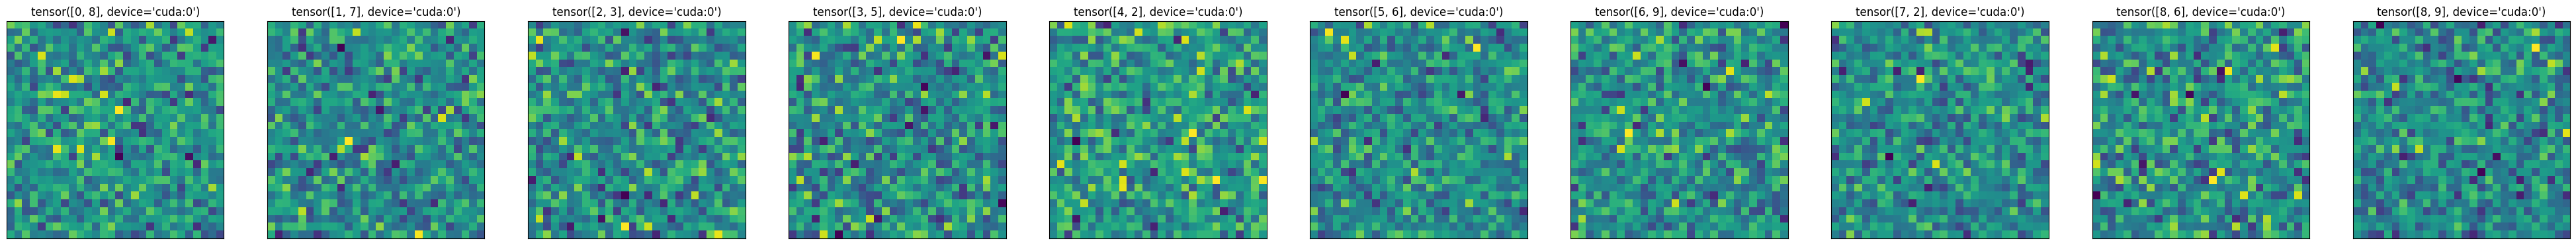

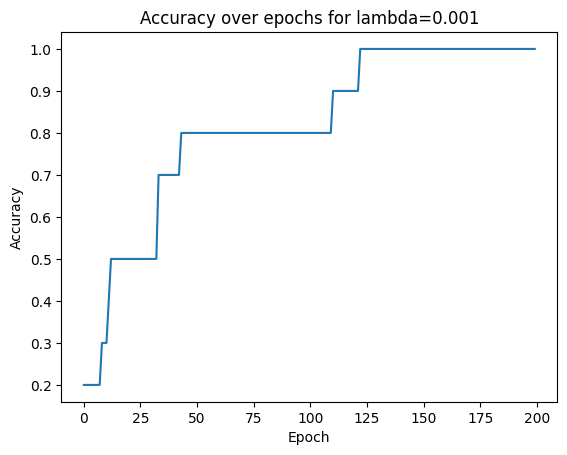

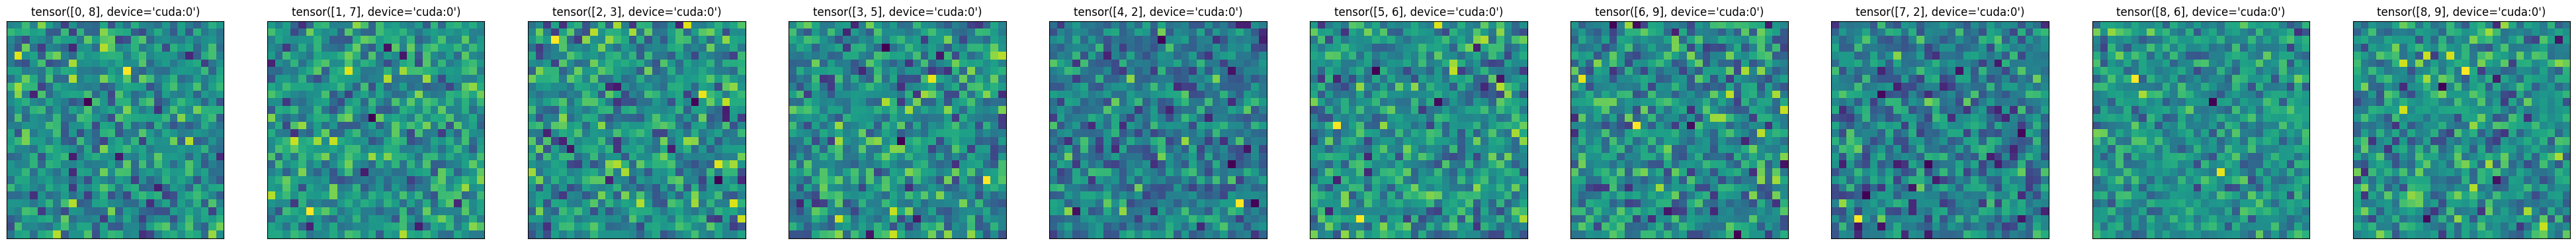

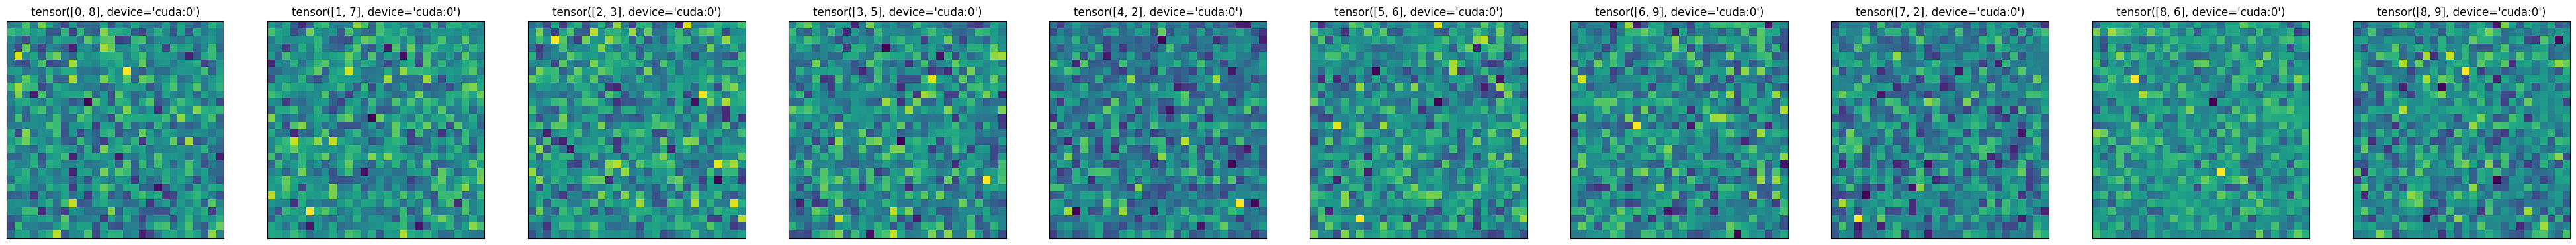

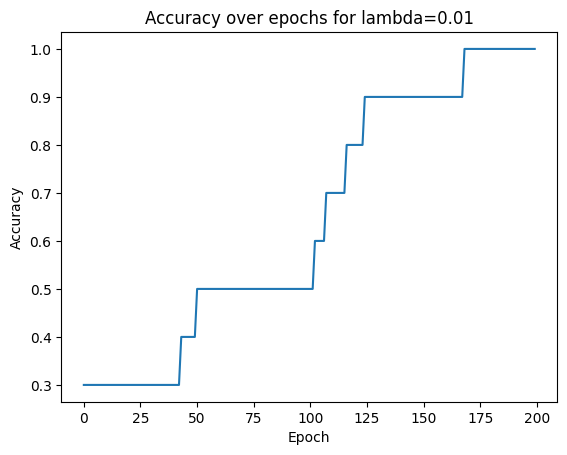

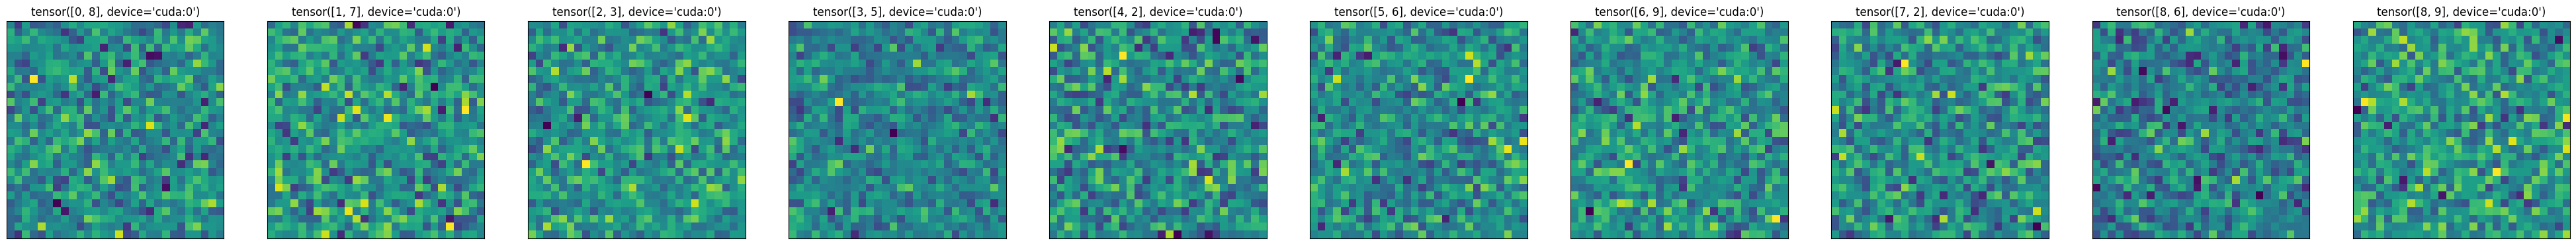

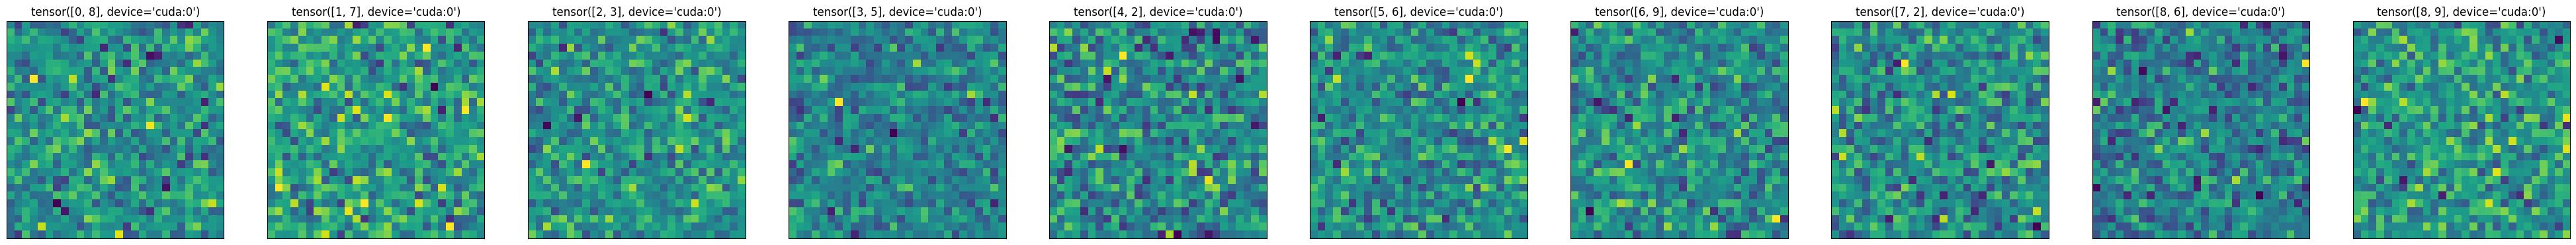

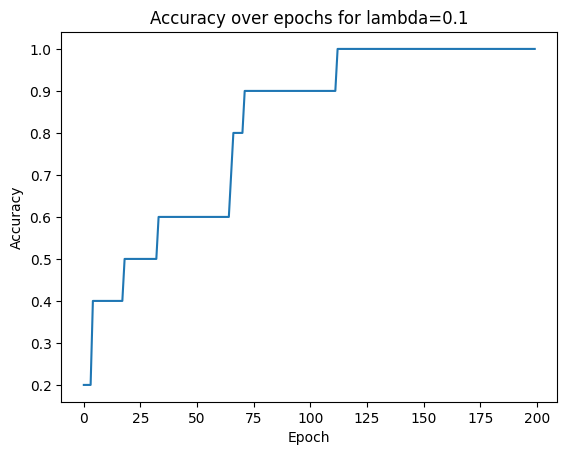

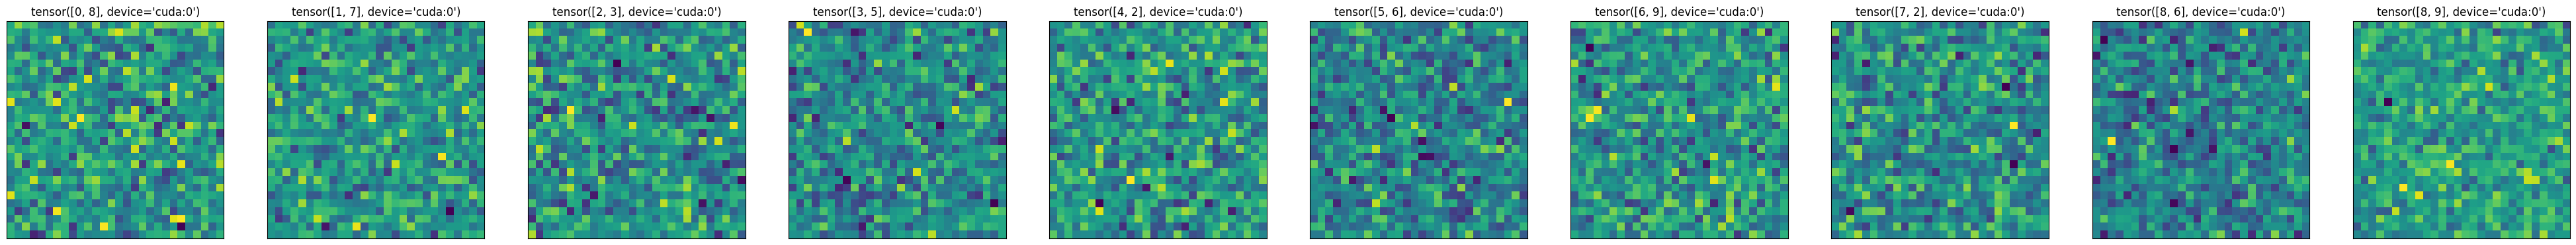

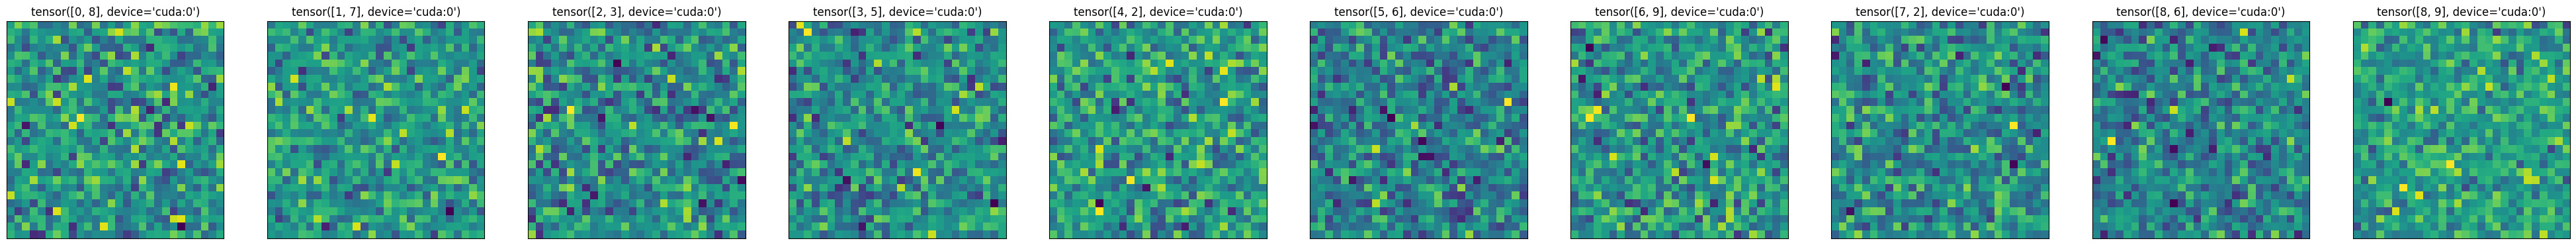

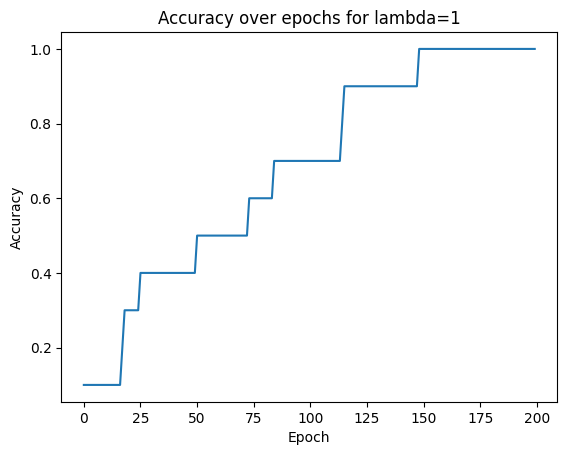

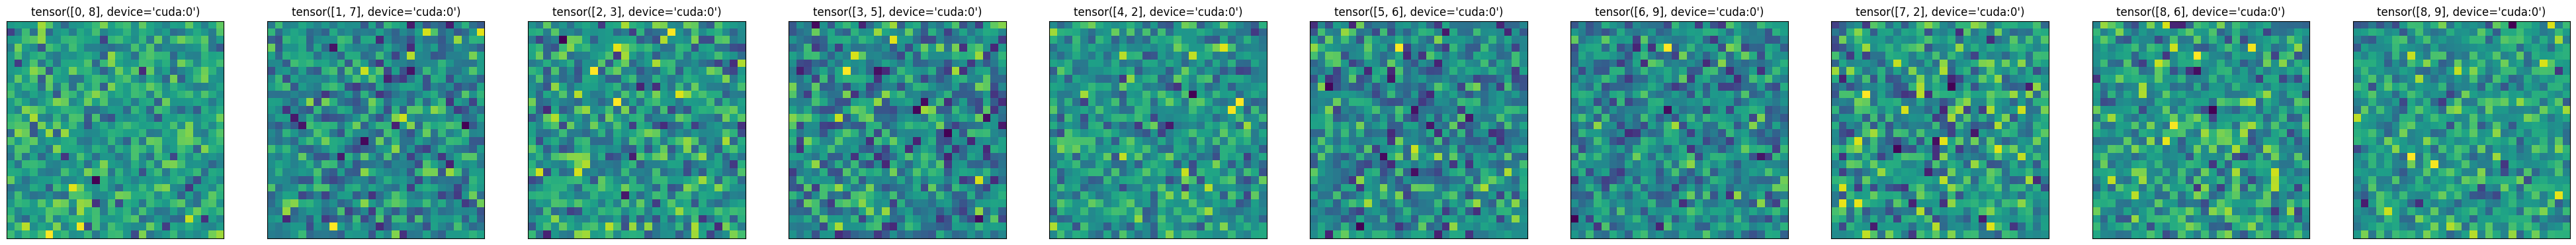

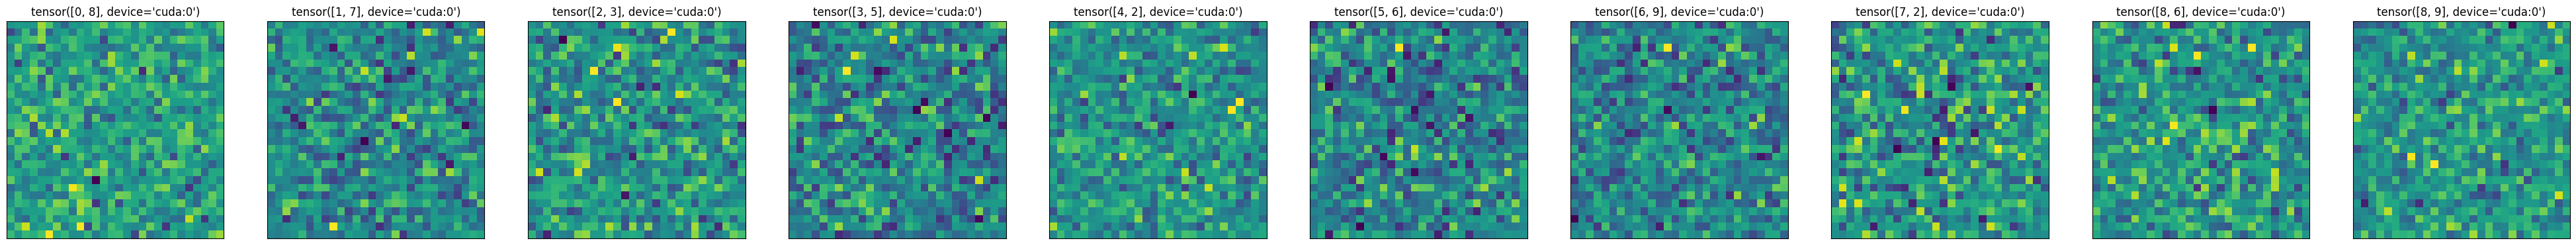

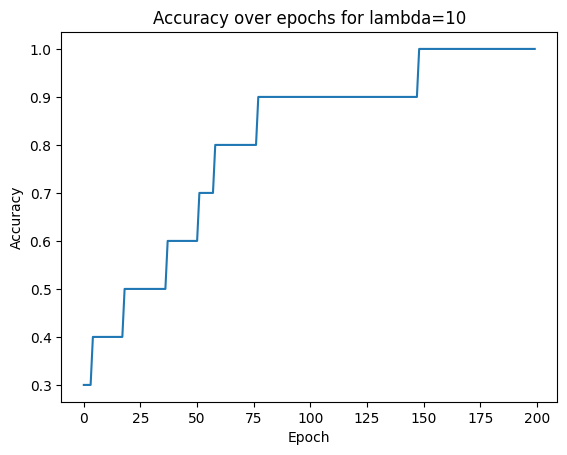

In [50]:
net.to(device)
net.requires_grad= False
labels=torch.tensor([[0,8],[1,7],[2,3],[3,5],[4,2],[5,6],[6,9],[7,2],[8,6],[8,9]])

for lambda_l2 in lambdas_l2:

  noised_inputs=torch.randn((10,1,28,28))
  starting_inputs=noised_inputs.clone()
  noised_inputs = noised_inputs.to(device)
  noised_inputs.requires_grad = True
  labels = labels.to(device)
  optimizer = torch.optim.Adam([noised_inputs], 0.001)   #initial and fixed learning rate of 0.001.


  accuracy=[]

  display_numbers(starting_inputs.cpu().detach().numpy())

  for epoch in range(200):  #  an epoch is a training run through the whole data set

      optimizer.zero_grad()

      batch_outputs = net(noised_inputs)   #this line calls the forward(self, x) method of the MLP object. Please note, that the last layer of the MLP is linear
                                            #and MLP doesn't apply
                                            #the nonlinear activation after the last layer
      loss = torch.nn.functional.cross_entropy(batch_outputs, labels[:,0],reduction = "mean")+torch.nn.functional.cross_entropy(batch_outputs, labels[:,1],reduction = "mean")+lambda_l2 * noised_inputs.pow(2).mean() #instead, nonlinear softmax is applied internally in THIS loss function
      loss.backward()       #this computes gradients as we have seen in previous workshops
      optimizer.step()


      good=0
      wrong=0
      with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
        for i in range(10): #batches in test are of size 1
          datapoint= noised_inputs[i]
          label = labels[i]

          prediction = net(datapoint.to(device))                  #prediction has values representing the "prevalence" of the corresponding class
          classification = torch.argmax(prediction)    #the class is the index of maximal "prevalence"

          if classification.item() in label:
            good += 1
          else:
            wrong += 1
      accuracy.append(good/(good+wrong))

  display_numbers(noised_inputs.cpu().detach().numpy())
  plt.show()
  plt.plot(accuracy)
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.title(f'Accuracy over epochs for lambda={lambda_l2}')
  plt.show()